In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
import os
import sys
import pandas as pd
import sympy
sys.path.append('../')  

import pysindy as ps
# Seed the random number generators for reproducibility
np.random.seed(100)

In [2]:
from test_data import *
from numpy.linalg import matrix_rank, svd
from itertools import product
from utils import plot_result_jacobi
from error_bounds import *
from matplotlib.colors import LinearSegmentedColormap
from jrc_analysis import *

In [3]:
#Defining colors for the plots: green = true , red = false
green=(100/255,250/255,100/255)#(0,1,0)
neutral_color = (1, 1, 1)  
red=(241/255,13/255,30/255)
cmap_green_red = LinearSegmentedColormap.from_list('RedGreen', [green,neutral_color,red], N=256)
cmap_red_green = LinearSegmentedColormap.from_list('GreenRed', [red,neutral_color,green], N=256)

We want to get a threshold and error bound for analysing a analytic or polynomial PDE as unique. We can reuse the functions from the SFranco method.

## Easy examples: $u_1 = x^2 + t^2$ and $u_2 = exp(x-at)$

In [4]:
n_samples=50
T,X,t,x = create_data_2d(T_start=-2, T_end=2, L_x_start=0,L_x_end=5, N_t=n_samples, N_x=n_samples)
np.random.seed(3)
a=np.random.randn()
x_sp = sympy.Symbol('x')
t_sp = sympy.Symbol('t')

#not unique
"""
u = X**2 + T**2
ux = 2*X
ut = 2*T
utx = 0*T
uxx = 2*np.ones(X.shape)
formula = x_sp**2+t_sp**2
"""

#not unqiue
u = np.exp(X-a*T)
formula = sympy.exp(x_sp-a*t_sp)
ux = u
ut = -a*u
utx = -a*u
uxx = u

"""
#analytic unique
u=(X + T)*np.arccos(1/np.cosh(a*T))
ut = a*(T + X)*np.sinh(T*a)/(np.sqrt(1 - 1/np.cosh(T*a)**2)*np.cosh(T*a)**2) + np.arccos(1/np.cosh(T*a))
ux = np.arccos(1/np.cosh(T*a))
utx = a*np.sinh(T*a)/(np.sqrt(1 - 1/np.cosh(T*a)**2)*np.cosh(T*a)**2)
uxx = np.zeros(X.shape)
formula = (x_sp + t_sp)*sympy.acos(1/sympy.cosh(a*t_sp))
"""
print("Formula: ", formula)
print(f"a {a}")
dt=t[1]-t[0]
dx=x[1]-x[0]

Formula:  exp(-1.78862847343032*t + x)
a 1.7886284734303186


#### Compare the error on finite differences on the Jacobian of $g = ( u | u_x)$

In [5]:
#Compute the derivatives
fd_order=2
ut_fd, utx_fd,ux_fd, uxx_fd = get_derivatives(u,dt,dx,fd_order,drop_endpoints=True,remove_endpoints=False)

#Filter out the boundary values
filter_func = utx_fd
ut_fd,ut = drop_endpoints(ut_fd,ut,filter_func)
utx_fd,utx = drop_endpoints(utx_fd,utx,filter_func)
ux_fd,ux = drop_endpoints(ux_fd,ux,filter_func)
uxx_fd,uxx = drop_endpoints(uxx_fd,uxx,filter_func)

X_filtered = drop_endpoints(X,X,filter_func)[0]
T_filtered = drop_endpoints(T,T,filter_func)[0]

##### Compare the upper bounds for different derivatives and the Jacobian

###### Without noise

Lets calculate an upper bound for the different derivatives

In [6]:
#Check  upper bound on derivatives
eps=1e-15
Cut, Cux, Cuxx, Cutx= get_Cut_Cux_Cuxx_Cutx(formula,X,T,fd_order)
bound_ut = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=Cut,Cxi=1.0,h=dt)
bound_ux = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=Cux,Cxi=1.0,h=dx)
bound_uxx = upper_bound_central_differences(eps,fd_order,order_derivative=2,Cu=Cuxx,Cxi=1.0,h=dx)
bound_utx = upper_bound_central_differences(bound_ut,fd_order,order_derivative=1,Cu=Cutx,Cxi=1.0,h=dx)

print(f" |ut_fd - ut| \t= {infinity_norm((ut_fd-ut).flatten()):.3e} <= {bound_ut:.3e}")
print(f" |ux_fd - ux| \t= {infinity_norm((ux_fd-ux).flatten()):.3e} <= {bound_ux:.3e}")
print(f" |uxx_fd - uxx|\t= {infinity_norm((uxx_fd-uxx).flatten()):.3e} <= {bound_uxx:.3e}")
print(f" |utx_fd - utx|\t= {infinity_norm((utx_fd-utx).flatten()):.3e} <= {bound_utx:.3e}")

 |ut_fd - ut| 	= 2.636e+01 <= 3.374e+01
 |ux_fd - ux| 	= 7.194e+00 <= 9.214e+00
 |uxx_fd - uxx|	= 3.596e+00 <= 1.843e+01
 |utx_fd - utx|	= 3.927e+01 <= 3.472e+02


Check wether upper bound is correct:
|JG-JG_fd|= 2.554e-01 <= 3.494e+02
Check wether upper bound is correct:
|JG-JG_fd|= 5.931e-02 <= 3.494e+02
Check wether upper bound is correct:
|JG-JG_fd|= 1.377e-02 <= 3.494e+02
Check wether upper bound is correct:
|JG-JG_fd|= 7.086e-01 <= 3.494e+02
Check wether upper bound is correct:
|JG-JG_fd|= 1.645e-01 <= 3.494e+02
Check wether upper bound is correct:
|JG-JG_fd|= 3.821e-02 <= 3.494e+02
Check wether upper bound is correct:
|JG-JG_fd|= 1.966e+00 <= 3.494e+02
Check wether upper bound is correct:
|JG-JG_fd|= 4.565e-01 <= 3.494e+02
Check wether upper bound is correct:
|JG-JG_fd|= 1.060e-01 <= 3.494e+02


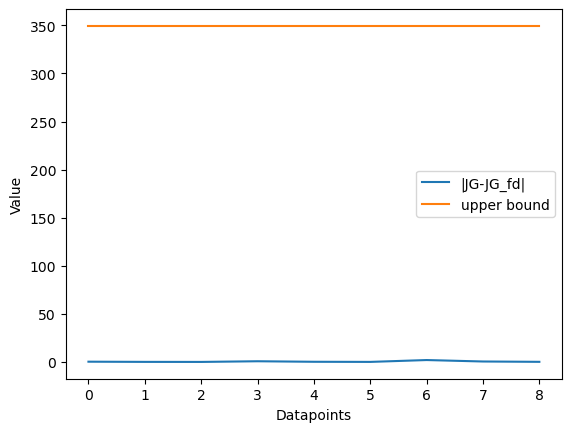

In [7]:
# Check upper bound on Jacobian
space_range = int(ut.shape[0]/10-1)
time_range = int(ut.shape[1]/10-1)
jacobians =[]
upperbounds=[]
for i in range(space_range):
    for j in range(time_range):
        x_i, t_j = i * 10 + 10, j * 10 + 10
        jacobian_fd = np.array([[ut_fd[x_i,t_j], ux_fd[x_i,t_j]], [utx_fd[x_i,t_j], uxx_fd[x_i,t_j]]]).reshape(2,2)
        jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)

        jacobian_diff = np.linalg.norm(jacobian_fd -jacobian)
        nr_datapoints=1
        upperbound = np.sqrt(bound_ut**2+bound_ux**2 + bound_uxx**2+bound_utx**2)

        jacobians.append(jacobian_diff)
        upperbounds.append(upperbound)

        print("Check wether upper bound is correct:")
        print(f"|JG-JG_fd|= {jacobian_diff:.3e} <= {upperbound:.3e}")

plt.plot(jacobians,label="|JG-JG_fd|")
plt.plot(upperbounds, label="upper bound")
plt.xlabel("Datapoints")
plt.ylabel("Value")
plt.legend()
plt.show()

Noise level 0
 |ut_fd - ut| 	= 2.636e+01 <= 3.374e+01
 |ux_fd - ux| 	= 7.194e+00 <= 9.214e+00
 |uxx_fd - uxx|	= 3.596e+00 <= 1.843e+01
 |utx_fd - utx|	= 3.927e+01 <= 3.472e+02
Upper bound 3.494e+02


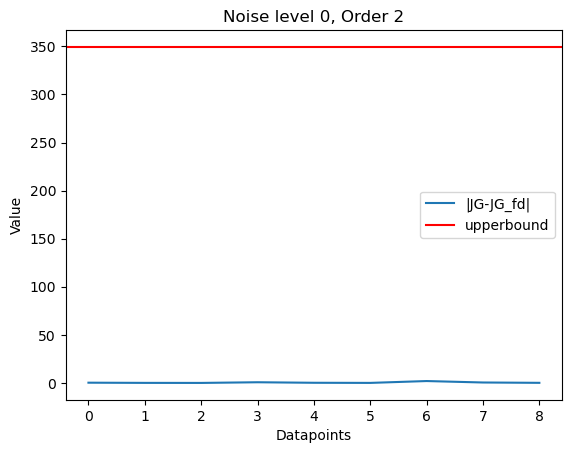

Noise level 1e-10
 |ut_fd - ut| 	= 2.636e+01 <= 3.374e+01
 |ux_fd - ux| 	= 7.194e+00 <= 9.214e+00
 |uxx_fd - uxx|	= 3.596e+00 <= 1.843e+01
 |utx_fd - utx|	= 3.927e+01 <= 3.472e+02
Upper bound 3.494e+02


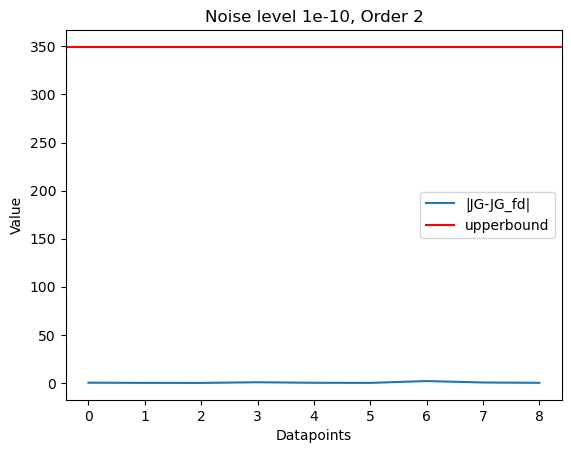

Noise level 1e-09
 |ut_fd - ut| 	= 2.636e+01 <= 3.374e+01
 |ux_fd - ux| 	= 7.194e+00 <= 9.214e+00
 |uxx_fd - uxx|	= 3.596e+00 <= 1.843e+01
 |utx_fd - utx|	= 3.927e+01 <= 3.472e+02
Upper bound 3.494e+02


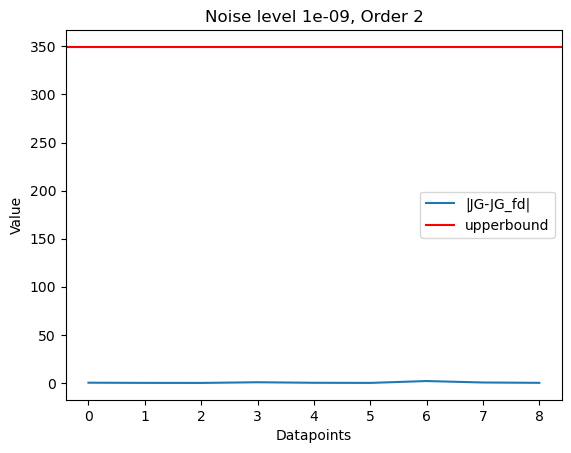

Noise level 1e-08
 |ut_fd - ut| 	= 2.636e+01 <= 3.374e+01
 |ux_fd - ux| 	= 7.194e+00 <= 9.214e+00
 |uxx_fd - uxx|	= 3.597e+00 <= 1.843e+01
 |utx_fd - utx|	= 3.927e+01 <= 3.472e+02
Upper bound 3.494e+02


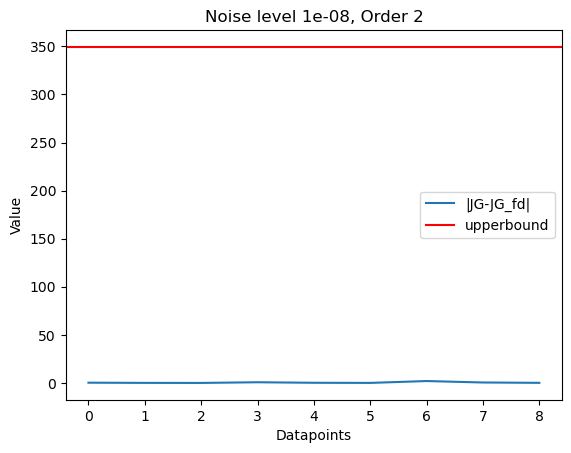

Noise level 1e-07
 |ut_fd - ut| 	= 2.636e+01 <= 3.375e+01
 |ux_fd - ux| 	= 7.193e+00 <= 9.216e+00
 |uxx_fd - uxx|	= 3.562e+00 <= 1.851e+01
 |utx_fd - utx|	= 3.927e+01 <= 3.472e+02
Upper bound 3.494e+02


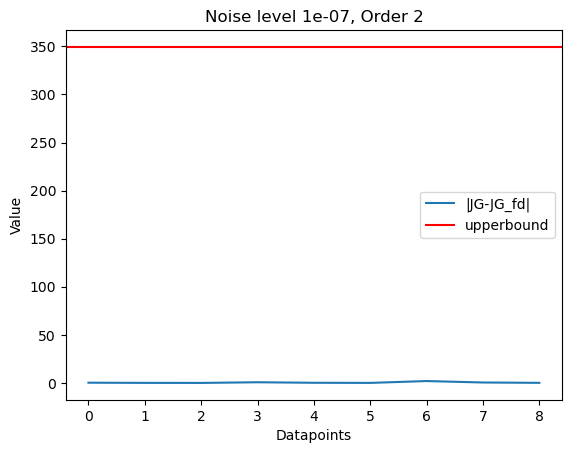

Noise level 1e-06
 |ut_fd - ut| 	= 2.636e+01 <= 3.377e+01
 |ux_fd - ux| 	= 7.196e+00 <= 9.232e+00
 |uxx_fd - uxx|	= 3.626e+00 <= 1.913e+01
 |utx_fd - utx|	= 3.925e+01 <= 3.474e+02
Upper bound 3.497e+02


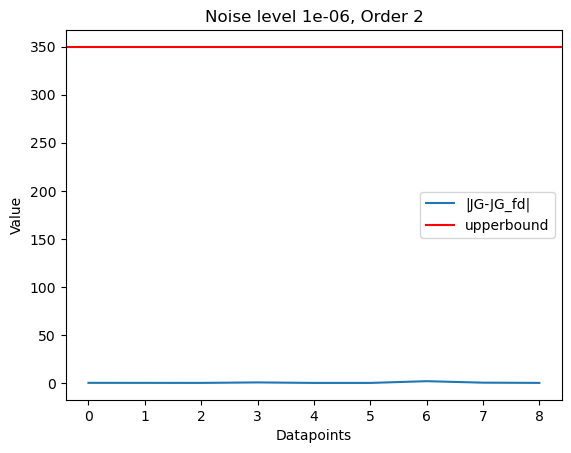

Noise level 1e-05
 |ut_fd - ut| 	= 2.643e+01 <= 3.396e+01
 |ux_fd - ux| 	= 7.162e+00 <= 9.385e+00
 |uxx_fd - uxx|	= 5.712e+00 <= 2.514e+01
 |utx_fd - utx|	= 3.912e+01 <= 3.493e+02
Upper bound 3.519e+02


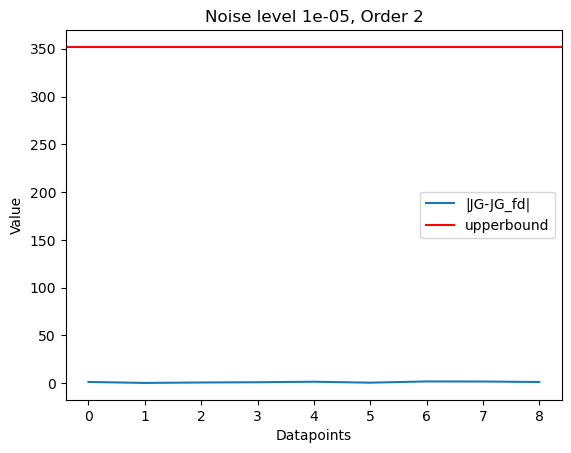

Noise level 0.0001
 |ut_fd - ut| 	= 2.684e+01 <= 3.573e+01
 |ux_fd - ux| 	= 7.072e+00 <= 1.081e+01
 |uxx_fd - uxx|	= 4.052e+01 <= 8.080e+01
 |utx_fd - utx|	= 3.968e+01 <= 3.667e+02
Upper bound 3.773e+02


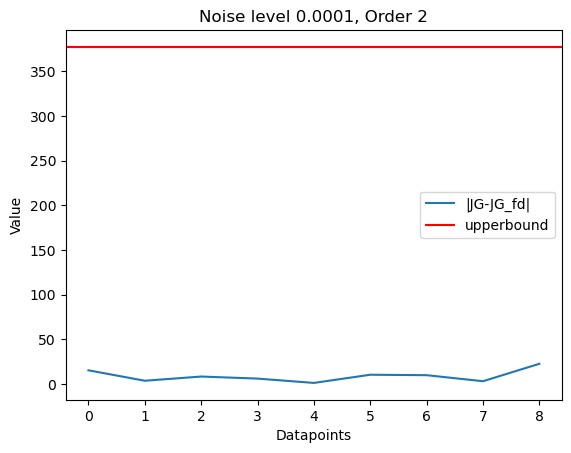

Noise level 0.001
 |ut_fd - ut| 	= 3.109e+01 <= 5.487e+01
 |ux_fd - ux| 	= 1.215e+01 <= 2.611e+01
 |uxx_fd - uxx|	= 4.290e+02 <= 6.809e+02
 |utx_fd - utx|	= 1.167e+02 <= 5.542e+02
Upper bound 8.800e+02


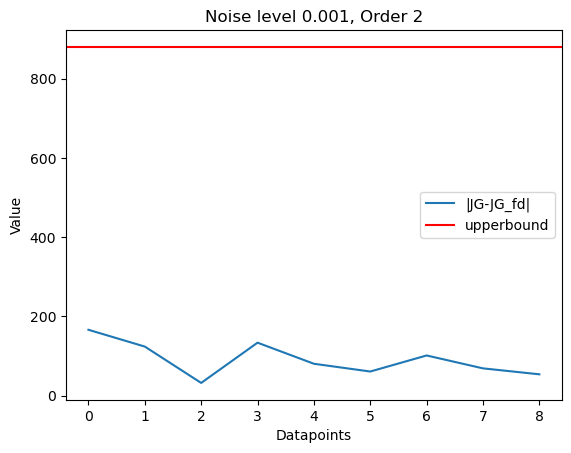

Noise level 0.01
 |ut_fd - ut| 	= 1.615e+02 <= 3.107e+02
 |ux_fd - ux| 	= 1.321e+02 <= 2.308e+02
 |uxx_fd - uxx|	= 4.195e+03 <= 8.703e+03
 |utx_fd - utx|	= 1.095e+03 <= 3.061e+03
Upper bound 9.233e+03


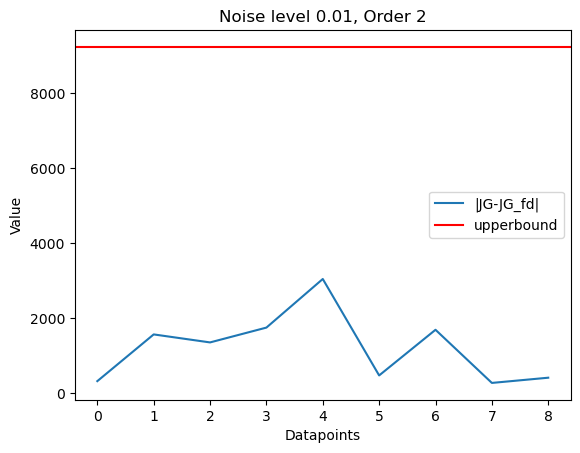

In [8]:
#Check upper bound on jacobian with noise
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
unorm2=np.sqrt(np.mean(np.square(u)))

for noise_level in noise_levels: 
    var = noise_level * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    u_noise = u + noise
    print(f"Noise level {noise_level}")
    #Calculate upper bounds
    eps = infinity_norm(u-u_noise)
    bound_ut = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=Cut ,Cxi=1.0,h=dt)
    bound_ux = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=Cux,Cxi=1.0,h=dx)
    bound_uxx = upper_bound_central_differences(eps,fd_order,order_derivative=2,Cu=Cuxx,Cxi=1.0,h=dx)
    bound_utx = upper_bound_central_differences(bound_ut,fd_order,order_derivative=1,Cu=Cutx,Cxi=1.0,h=dx)
    
    #Calculate derivatives
    ut_fd, utx_fd,ux_fd, uxx_fd= get_derivatives(u_noise,dt,dx,fd_order)
    
    print(f" |ut_fd - ut| \t= {infinity_norm((ut_fd-ut).flatten()):.3e} <= {bound_ut:.3e}")
    print(f" |ux_fd - ux| \t= {infinity_norm((ux_fd-ux).flatten()):.3e} <= {bound_ux:.3e}")
    print(f" |uxx_fd - uxx|\t= {infinity_norm((uxx_fd-uxx).flatten()):.3e} <= {bound_uxx:.3e}")
    print(f" |utx_fd - utx|\t= {infinity_norm((utx_fd-utx).flatten()):.3e} <= {bound_utx:.3e}")
    
    jacobians =[]
    #Calculate upper bound which stays constant for all data points(only changes in noise level)
    nr_datapoints=1
    upperbound = np.sqrt(bound_ut**2+bound_ux**2 + bound_uxx**2+bound_utx**2)
    print(f"Upper bound {upperbound:.3e}")
    for i in range(space_range):
        for j in range(time_range):
            #Compute differenc between true Jacobian and finite difference Jacobian
            x_i, t_j = i * 10 + 10, j * 10 + 10
            jacobian_fd = np.array([[ut_fd[x_i,t_j], ux_fd[x_i,t_j]], [utx_fd[x_i,t_j], uxx_fd[x_i,t_j]]]).reshape(2,2)
            jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)
            jacobian_diff = np.linalg.norm(jacobian_fd -jacobian)    
            jacobians.append(jacobian_diff)
    
            #print("Check wether upper bound is correct:")
            #print(f"|JG-JG_fd|= {jacobian_diff:.3e} <= {upperbound:.3e}")
    plt.title(f"Noise level {noise_level}, Order {fd_order}")
    plt.plot(jacobians,label="|JG-JG_fd|")
    plt.axhline(y=upperbound, color='r', linestyle='-',label="upperbound")
    plt.xlabel("Datapoints")
    plt.ylabel("Value")
    plt.legend()
    filename = f"Images/noise_{noise_level}_order_{fd_order}.png"
    plt.savefig(filename)
    plt.show()

Compare Jacobians and singular values

In [9]:
space_range = int(ut.shape[1]/10-2)
time_range = int(ut.shape[0]/10-2)

#For saving results
svs = np.zeros([space_range, time_range])
svs_fd = np.zeros([space_range, time_range])
upper_bounds = np.zeros([space_range, time_range])
lower_bounds = np.zeros([space_range, time_range])

ut_fd, utx_fd,ux_fd, uxx_fd = get_derivatives(u,dt,dx,fd_order)

for i in range(space_range):
    for j in range(time_range):
        x_i, t_j = i * 10 + 10, j * 10 + 10
        jacobian_fd = np.array([[ut_fd[x_i,t_j], ux_fd[x_i,t_j]], [utx_fd[x_i,t_j], uxx_fd[x_i,t_j]]]).reshape(2,2)
        jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)
        

        sv = svd(jacobian, compute_uv=False)
        sv_fd = svd(jacobian_fd, compute_uv=False)
        sv_min,sv_min_fd =sv  [-1],sv_fd[-1]
        sv_max,sv_max_fd =sv[0],sv_fd[0]

        #Save the results 
        svs[i,j] = sv_min/sv_max
        svs_fd[i,j] =sv_min_fd/sv_max_fd
        jacobian_diff=np.linalg.norm(jacobian_fd -jacobian)
        upper_bound_jacobian = get_upper_bound_jacobian(1e-16,fd_order,Cut,Cux,Cuxx,Cutx,dt,dx)
        print("Jacobian diff ", jacobian_diff, "upper_bound_jacobian",upper_bound_jacobian)
        
        C1=sv_max*1.5 #C1 => o_max
        C=sv_max*0.5 #C <= o_max
        C2=1e-4
        lower_bound = lower_bound_nonsingular_matrix(C1,C2,jacobian_diff)
        upper_bound = upper_bound_singular_matrix(C,jacobian_diff)

        lower_bound_nonexact = lower_bound_nonsingular_matrix(C1,C2,upper_bound_jacobian)
        upper_bound_nonexact = upper_bound_singular_matrix(C,upper_bound_jacobian)

        lower_bounds[i,j]=lower_bound
        upper_bounds[i,j]=upper_bound
        
        print(f" Comparison at x = {x_i}, t = {t_j} ")
        print(f" \t \t \t \t Original \t FD \t \t diff")
        print(f" Smallest singular values \t {sv_min:.3e}\t  {sv_min_fd:.3e} \t {np.abs(sv_min-sv_min_fd):.3e}")
        print(f" Biggest singular values \t {sv_max:.3e}\t  {sv_max_fd:.3e} \t {np.abs(sv_max-sv_max_fd):.3e}")
        print(f" Differences Jacobian \t \t {jacobian_diff:.3e} <= {upper_bound_jacobian:.3e}")
        print(" Bounds with jacobian difference")
        print(f" \t Lower bound for uniqueness: \t  {svs_fd[i,j]:.3e} >= {lower_bound:.3e}")
        print(f" \t Upper bound for non uniqueness:  {svs_fd[i,j]:.3e} <= {upper_bound:.3e}")
        print(" Bounds with upper bound on jacobian difference")
        print(f" \t Lower bound for uniqueness: \t  {svs_fd[i,j]:.3e} >= {lower_bound_nonexact:.3e}")
        print(f" \t Upper bound for non uniqueness:  {svs_fd[i,j]:.3e} <= {upper_bound_nonexact:.3e}")
        print(f" True ratio: \t  \t \t  {svs[i,j]:.3e} ")

Jacobian diff  0.2554043136692312 upper_bound_jacobian 349.4125662912489
 Comparison at x = 10, t = 10 
 	 	 	 	 Original 	 FD 	 	 diff
 Smallest singular values 	 3.101e-15	  3.549e-02 	 3.549e-02
 Biggest singular values 	 6.392e+01	  6.415e+01 	 2.355e-01
 Differences Jacobian 	 	 2.554e-01 <= 3.494e+02
 Bounds with jacobian difference
 	 Lower bound for uniqueness: 	  5.532e-04 >= 0.000e+00
 	 Upper bound for non uniqueness:  5.532e-04 <= 8.056e-03
 Bounds with upper bound on jacobian difference
 	 Lower bound for uniqueness: 	  5.532e-04 >= 0.000e+00
 	 Upper bound for non uniqueness:  5.532e-04 <= 1.000e+00
 True ratio: 	  	 	  4.851e-17 
Jacobian diff  0.05930792603622601 upper_bound_jacobian 349.4125662912489
 Comparison at x = 10, t = 20 
 	 	 	 	 Original 	 FD 	 	 diff
 Smallest singular values 	 7.752e-16	  8.242e-03 	 8.242e-03
 Biggest singular values 	 1.484e+01	  1.490e+01 	 5.469e-02
 Differences Jacobian 	 	 5.931e-02 <= 3.494e+02
 Bounds with jacobian difference
 	 Lo

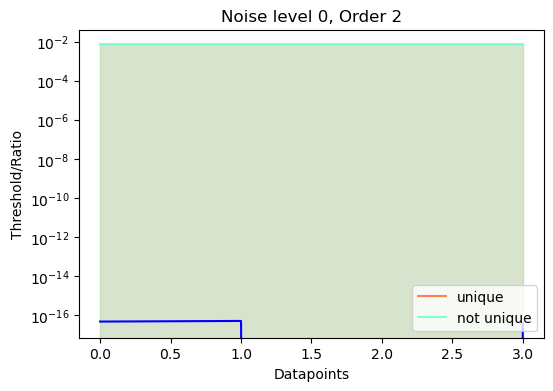

In [10]:
# Create subplots
plot_ratio_upper_lower_old(svs,lower_bounds,upper_bounds,f"Noise level {0}, Order {fd_order}")

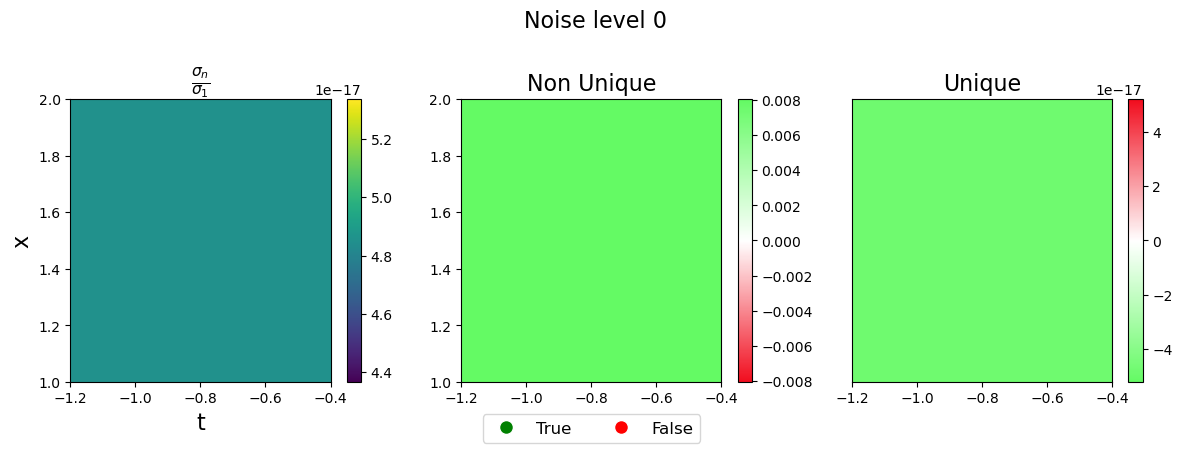

In [11]:
plot_results(upper_bounds,lower_bounds,svs,time_range,space_range,t,x,subtitle=f"Noise level {0}")

### Test different noise levels on easy examples

Noise level 0
Noise level 1e-08
Noise level 1e-05
Noise level 0.01


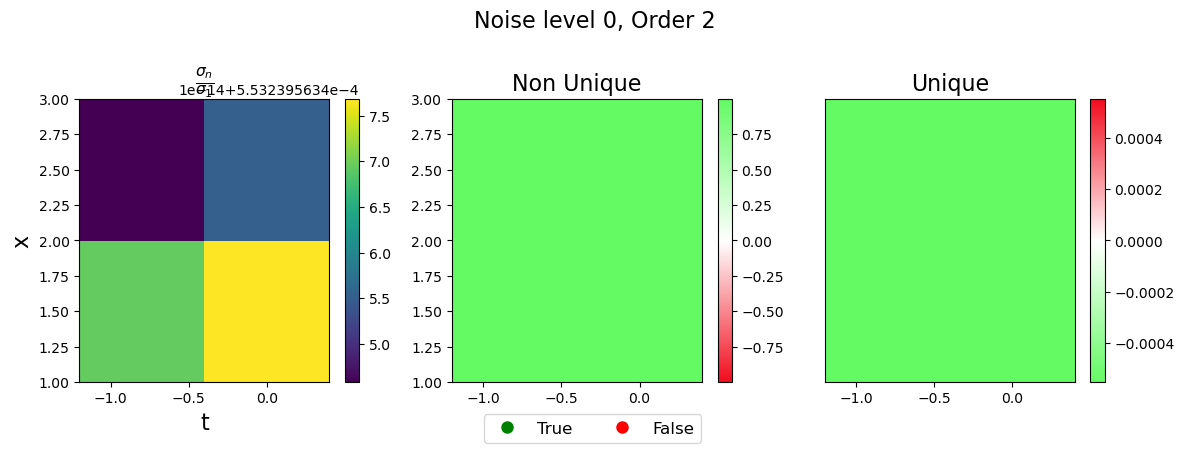

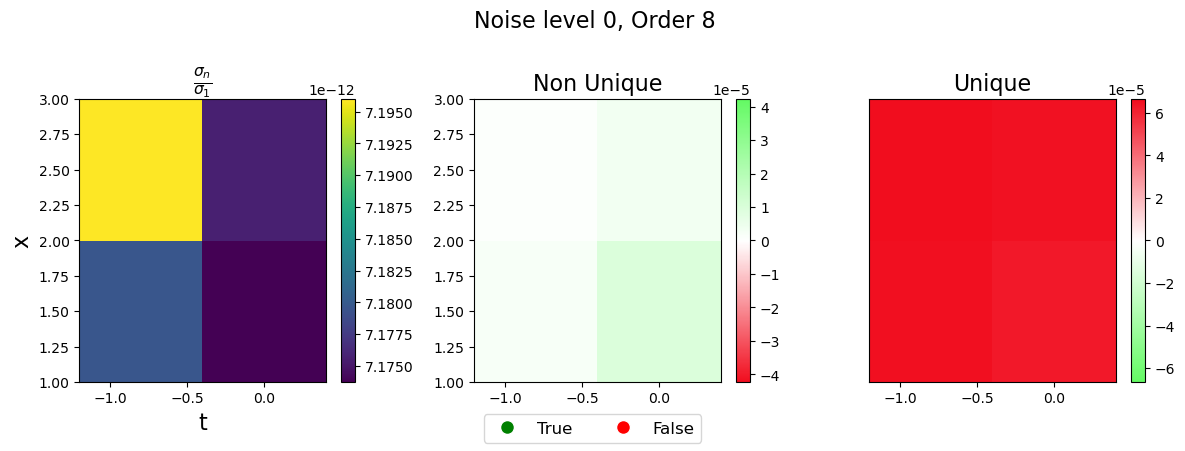

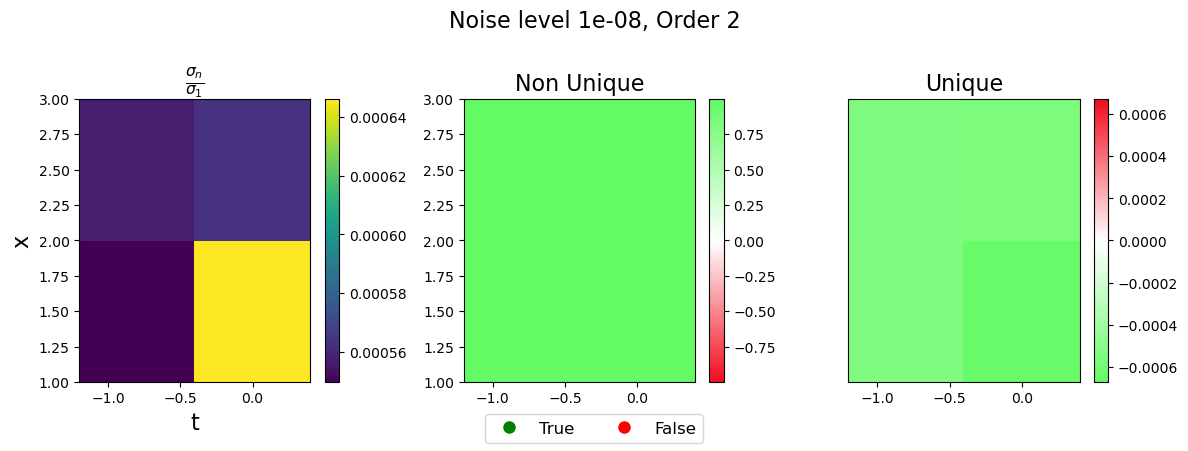

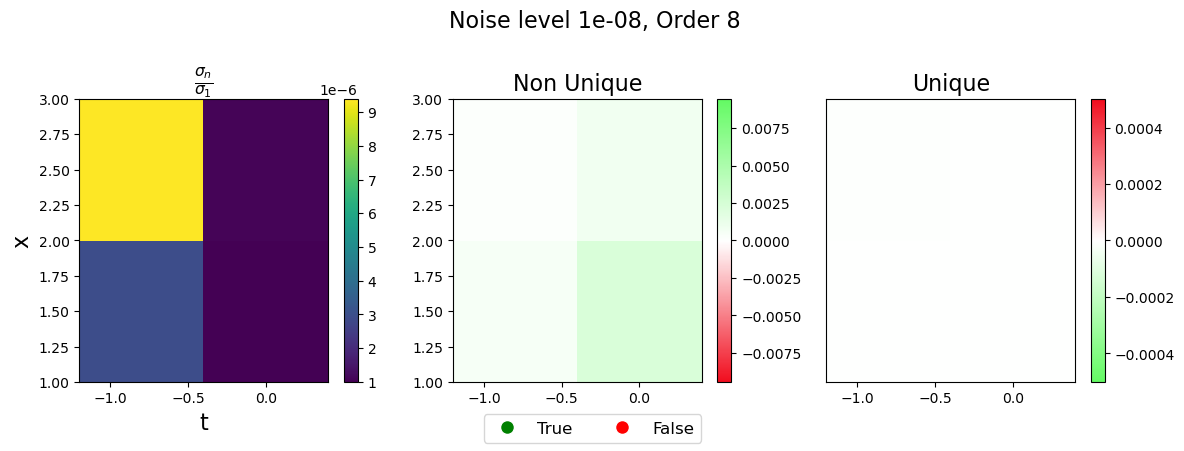

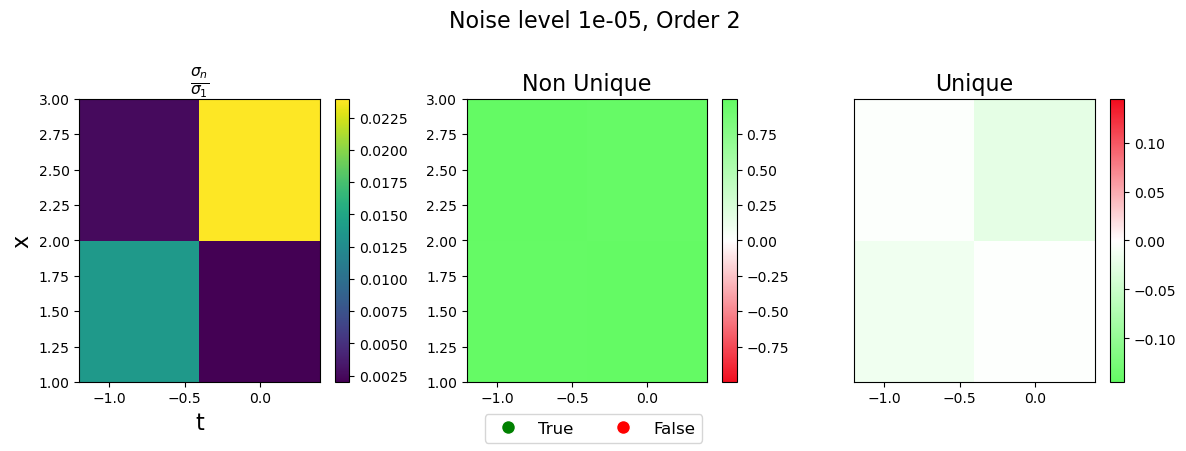

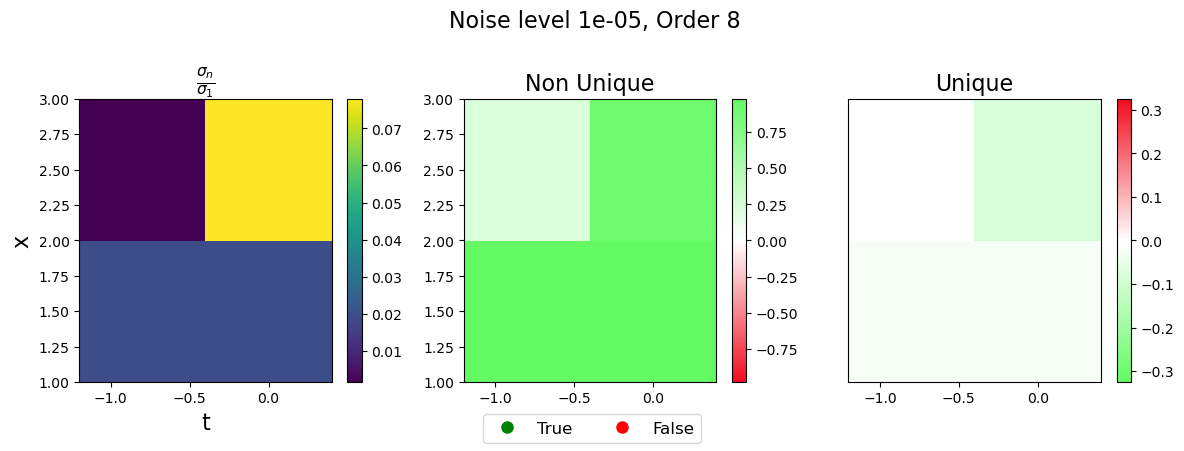

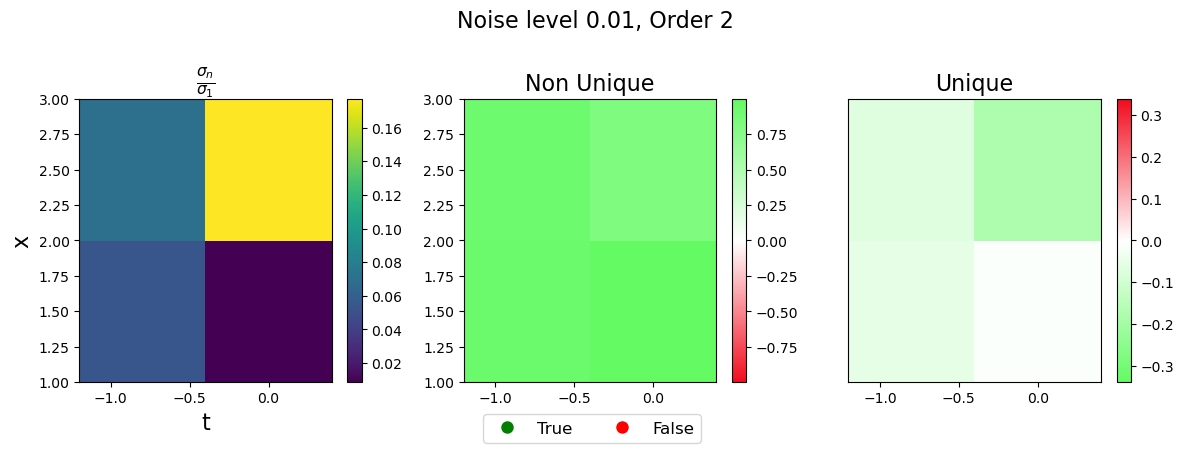

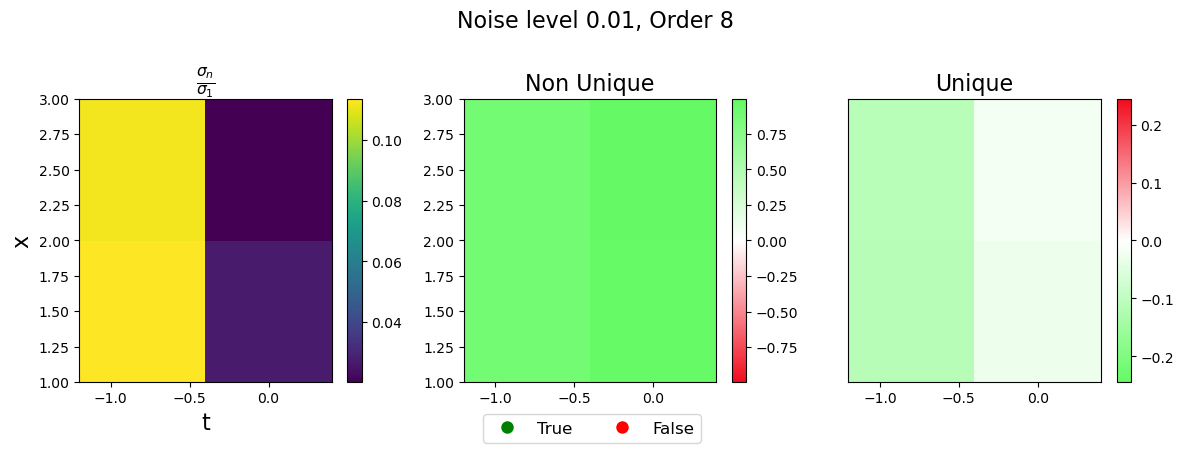

In [7]:
M=infinity_norm(u)
fd_orders=(2,8)
number_noise=10 #<=10
#noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
noise_levels = [0,1e-08,1e-05,1e-02]
orders=range(2,10,2)
unorm2=np.sqrt(np.mean(np.square(u)))
C_upper_bounds_deriv_fd_order0 = get_Cut_Cux_Cuxx_Cutx(formula,X,T,fd_orders[0])
C_upper_bounds_deriv_fd_order1 = get_Cut_Cux_Cuxx_Cutx(formula,X,T,fd_orders[1])

for noise_level in noise_levels:    
    
    var = noise_level * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    u_noise = u + noise
    eps = infinity_norm(u-u_noise)
    
    print(f"Noise level {noise_level}")
    fd_orders=(2,8)
    svs, lower_bounds,upper_bounds,space_range,time_range = get_results(u_noise,C_upper_bounds_deriv_fd_order0,fd_orders[0],dt,dx,eps)
    plot_results(upper_bounds, lower_bounds,svs,time_range,space_range,t,x,subtitle=f"Noise level {noise_level}, Order {fd_orders[0]}")
    svs, lower_bounds,upper_bounds,space_range,time_range = get_results(u_noise,C_upper_bounds_deriv_fd_order1,fd_orders[1],dt,dx,eps)
    plot_results(upper_bounds, lower_bounds,svs,time_range,space_range,t,x,subtitle=f"Noise level {noise_level}, Order {fd_orders[1]}")

In [8]:
M=infinity_norm(u)
number_noise=10 #<=10
#noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
noise_levels = [0,1e-08,1e-05,1e-02]
orders=range(2,10,2)
unorm2=np.sqrt(np.mean(np.square(u)))

for noise_level in noise_levels:    
    
    var = noise_level * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    u_noise = u + noise
    eps = infinity_norm(u-u_noise)
    
    print(f"Noise level {noise_level}")
    fd_orders=(2,8)
    svs, lower_bounds,upper_bounds,space_range,time_range = get_results(u_noise,C_upper_bounds_deriv_fd_order0,fd_orders[0],dt,dx,eps)
    print(f"Order {fd_orders[0]}")
    print(" \t omax/omin \t \t \t  lower_bounds \t \t upper_bounds")
    #Print Values
    for val_svs,val_lb, val_ub in zip(svs,lower_bounds, upper_bounds):
        print(" \t ",val_svs, " \t ", val_lb, " \t ", val_ub)
    svs, lower_bounds,upper_bounds,space_range,time_range = get_results(u_noise,C_upper_bounds_deriv_fd_order1,fd_orders[1],dt,dx,eps)
    print(f"Order {fd_orders[1]}")
    for val_svs,val_lb, val_ub in zip(svs,lower_bounds, upper_bounds):
        print(" \t ",val_svs, " \t ", val_lb, " \t ", val_ub)

Noise level 0
Order 2
 	 omax/omin 	 	 	  lower_bounds 	 	 upper_bounds
 	  [0.00055324 0.00055324 0.00055324]  	  [0. 0. 0.]  	  [1. 1. 1.]
 	  [0.00055324 0.00055324 0.00055324]  	  [0. 0. 0.]  	  [1. 1. 1.]
 	  [0.00055324 0.00055324 0.00055324]  	  [0. 0. 0.]  	  [1. 1. 1.]
Order 8
 	  [7.17972326e-12 7.17374401e-12 7.17880560e-12]  	  [6.59070080e-05 6.33952724e-05 5.25788504e-05]  	  [2.27883095e-06 9.81365694e-06 4.22630130e-05]
 	  [7.19599416e-12 7.17570249e-12 7.17529292e-12]  	  [6.63928493e-05 6.54874974e-05 6.15886987e-05]  	  [8.21398379e-07 3.53728874e-06 1.52331978e-05]
 	  [7.20097023e-12 7.18531629e-12 7.17895893e-12]  	  [6.65679698e-05 6.62416374e-05 6.48363184e-05]  	  [2.96071074e-07 1.27500502e-06 5.49071898e-06]
Noise level 1e-08
Order 2
 	 omax/omin 	 	 	  lower_bounds 	 	 upper_bounds
 	  [0.00055345 0.00047987 0.00032021]  	  [0. 0. 0.]  	  [1. 1. 1.]
 	  [0.00055948 0.00050396 0.00058321]  	  [0. 0. 0.]  	  [1. 1. 1.]
 	  [0.00055125 0.00055362 0.00055891]  

## Try it on different examples

In [9]:
experiment_names= ['algebraic_nonunique_kdv','algebraic_nonunique_1','analytic_unique_1','analytic_unique_2','analytic_nonunique_1']

### Perform on one experiment

In [18]:
experiment_name = experiment_names[0]
C2_param = 1e-4
fd_order=8
u,x,t,formula = experiment_data(n_samples=150,experiment_name=experiment_name)
dx=x[1]-x[0]
dt=t[1]-t[0]
print(f"Performing experiment {experiment_name} {formula} with order {fd_order}, C2 = {C2_param:.2e}")
subtitle=f"Experiment {experiment_name} {formula}, Order {fd_order}, C2_param = {C2_param:.2e}"
T,X = np.meshgrid(t,x)
C_upper_bounds_deriv = get_Cut_Cux_Cuxx_Cutx(formula,X,T,fd_order)

Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 8, C2 = 1.00e-04


In [19]:
noise_level=0
u_noise = add_noise(u,noise_level)
eps = infinity_norm(u-u_noise)
svs, lower_bounds,upper_bounds,space_range,time_range = get_results(u_noise,C_upper_bounds_deriv,fd_order,dt,dx,eps,C2_param)  

In [24]:
svs

array([[1.80230998e-12, 8.78520532e-13, 6.27725797e-13, 4.46812390e-13,
        1.62764753e-13, 7.94584472e-15, 7.32147500e-15, 3.20087260e-13,
        6.53350590e-13, 6.87174915e-13, 1.67578033e-12, 7.10131703e-13,
        5.53316409e-13],
       [3.80704450e-13, 8.36260164e-13, 3.25575603e-13, 8.02246204e-13,
        4.99244426e-13, 4.26877560e-14, 9.25205905e-13, 2.87613255e-13,
        1.31018682e-14, 9.61358012e-14, 3.58920355e-13, 7.79882045e-13,
        4.36726340e-13],
       [4.76756160e-13, 7.14107303e-13, 3.54775912e-13, 1.86161856e-12,
        3.76487928e-13, 4.55399018e-15, 3.29662237e-13, 3.74107159e-13,
        3.86098790e-13, 5.36358943e-14, 3.75236654e-14, 5.59457293e-14,
        3.27430264e-13],
       [1.74341332e-12, 1.46544352e-12, 1.11789202e-12, 4.04990682e-13,
        1.08721472e-12, 1.01931061e-12, 1.53946084e-12, 7.00115338e-13,
        2.11330846e-14, 3.85733340e-13, 3.02175804e-13, 8.69913374e-14,
        1.06452952e-14],
       [3.22143846e-13, 5.21668199e-

In [25]:
lower_bounds

array([[6.66666666e-05, 6.66666666e-05, 6.66666666e-05, 6.66666666e-05,
        6.66666666e-05, 6.66666666e-05, 6.66666666e-05, 6.66666666e-05,
        6.66666666e-05, 6.66666666e-05, 6.66666666e-05, 6.66666666e-05,
        6.66666666e-05],
       [6.66666666e-05, 6.66666666e-05, 6.66666666e-05, 6.66666666e-05,
        6.66666666e-05, 6.66666666e-05, 6.66666666e-05, 6.66666666e-05,
        6.66666666e-05, 6.66666666e-05, 6.66666666e-05, 6.66666666e-05,
        6.66666666e-05],
       [6.66666666e-05, 6.66666666e-05, 6.66666666e-05, 6.66666666e-05,
        6.66666666e-05, 6.66666666e-05, 6.66666666e-05, 6.66666666e-05,
        6.66666666e-05, 6.66666666e-05, 6.66666666e-05, 6.66666666e-05,
        6.66666666e-05],
       [6.66666666e-05, 6.66666666e-05, 6.66666666e-05, 6.66666666e-05,
        6.66666666e-05, 6.66666666e-05, 6.66666666e-05, 6.66666666e-05,
        6.66666666e-05, 6.66666666e-05, 6.66666666e-05, 6.66666666e-05,
        6.66666666e-05],
       [6.66666667e-05, 6.66666667e-

In [20]:
upper_bounds

array([[5.42590244e-14, 5.46858154e-14, 5.50029108e-14, 5.52198152e-14,
        5.53531980e-14, 5.54202956e-14, 5.54329134e-14, 5.53935823e-14,
        5.52947577e-14, 5.51212310e-14, 5.48552234e-14, 5.44829169e-14,
        5.40006251e-14],
       [5.30228306e-14, 5.36542724e-14, 5.41998400e-14, 5.46400106e-14,
        5.49701007e-14, 5.51983412e-14, 5.53408769e-14, 5.54152237e-14,
        5.54341036e-14, 5.54012793e-14, 5.53103604e-14, 5.51468402e-14,
        5.48929171e-14],
       [5.15592002e-14, 5.22536328e-14, 5.29419353e-14, 5.35817841e-14,
        5.41390894e-14, 5.45925733e-14, 5.49357851e-14, 5.51756071e-14,
        5.53275606e-14, 5.54093485e-14, 5.54345474e-14, 5.54081334e-14,
        5.53249011e-14],
       [5.02681910e-14, 5.08290457e-14, 5.14768015e-14, 5.21689134e-14,
        5.28603184e-14, 5.35080678e-14, 5.40767956e-14, 5.45434999e-14,
        5.48999404e-14, 5.51515800e-14, 5.53132192e-14, 5.54026532e-14,
        5.54342460e-14],
       [4.95261401e-14, 4.97882991e-

Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 8, C2 = 1.00e-04


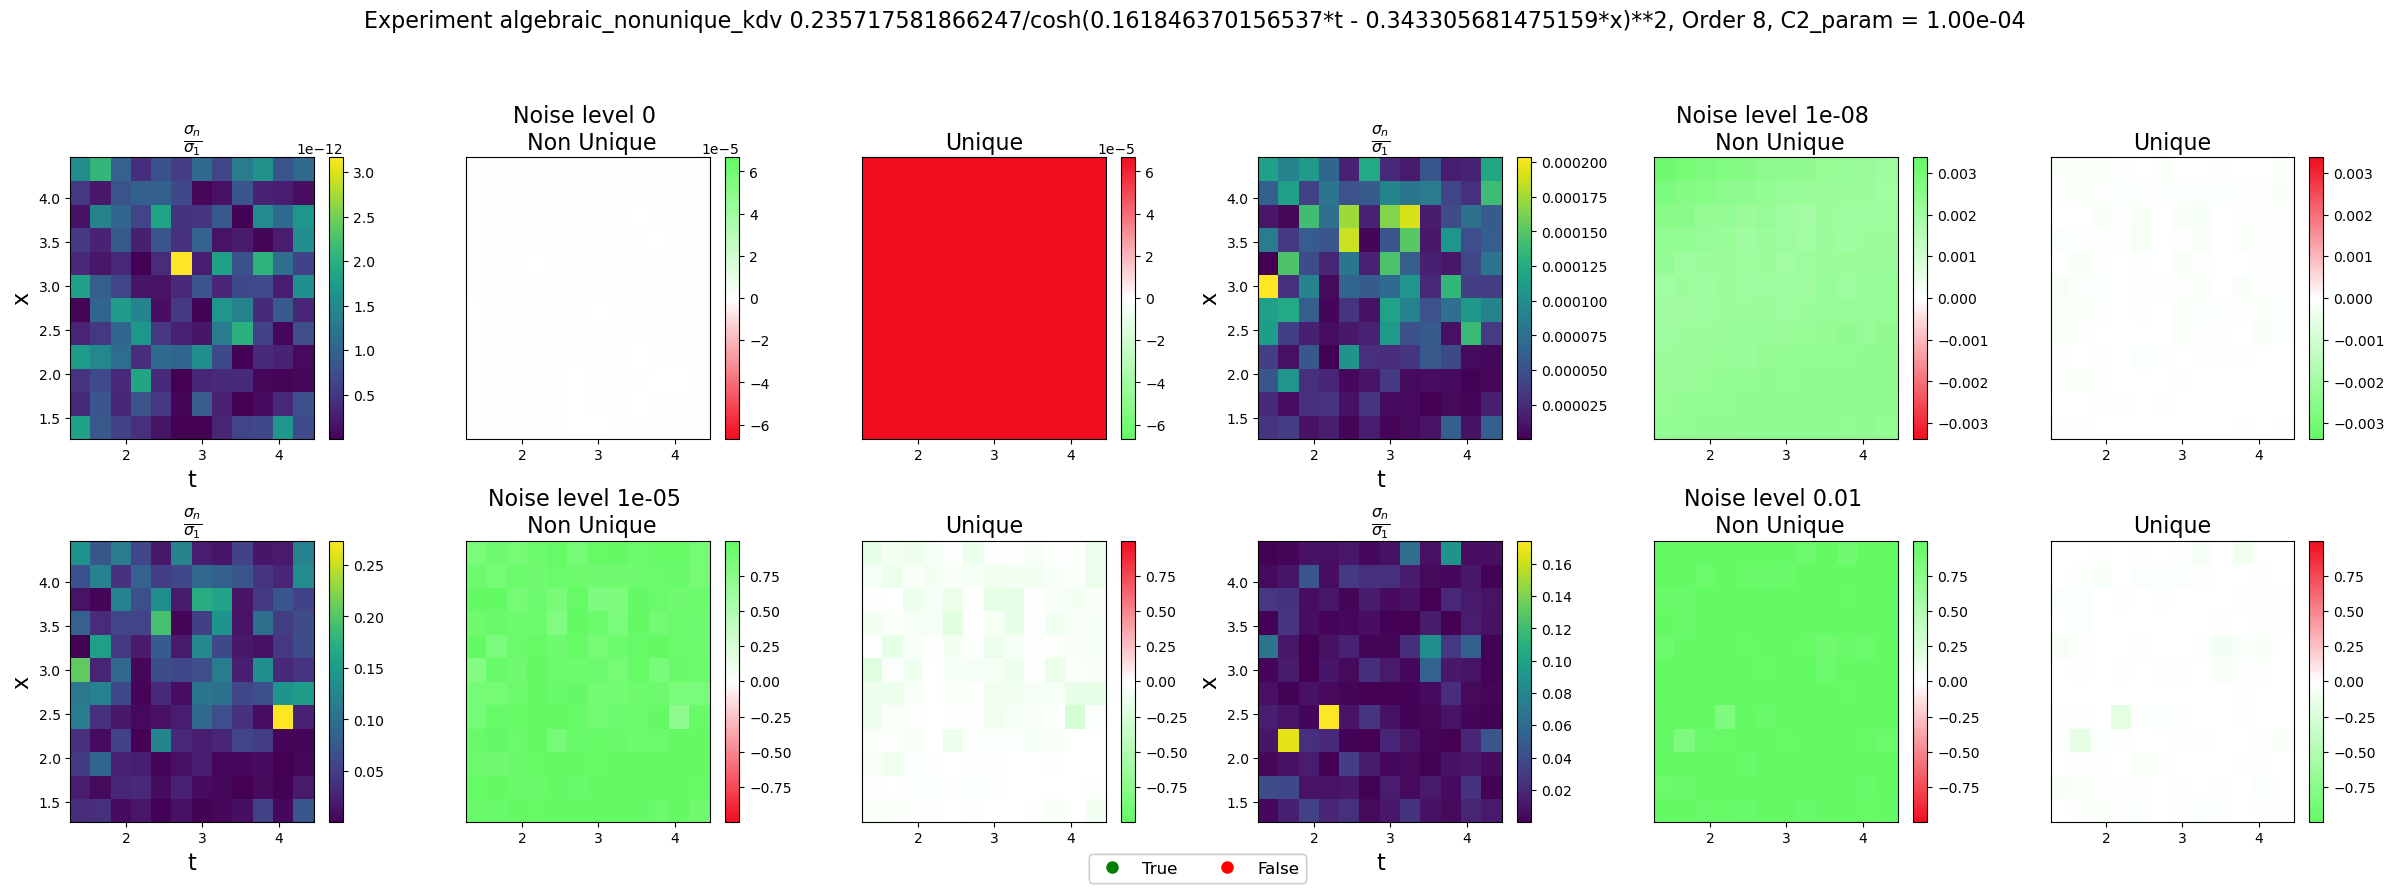

In [29]:
noise_levels = [0,1e-08,1e-05,0.01]
experiment_name = experiment_names[0]
perform_experiment(noise_levels,fd_order,experiment_name,C2_param=C2_param)

### Perform on all experiments

Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 2, C2 = 1.00e-03
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 8, C2 = 1.00e-03
Performing experiment algebraic_nonunique_1 1/(t + x) with order 2, C2 = 1.00e-03
Performing experiment algebraic_nonunique_1 1/(t + x) with order 8, C2 = 1.00e-03
Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.471435163732493*t)) with order 2, C2 = 1.00e-03
Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.471435163732493*t)) with order 8, C2 = 1.00e-03
Performing experiment analytic_unique_2 (t + x)*asin(1/cosh(0.471435163732493*t)) with order 2, C2 = 1.00e-03
Performing experiment analytic_unique_2 (t + x)*asin(1/cosh(0.471435163732493*t)) with order 8, C2 = 1.00e-03
Performing experiment analytic_nonunique_1 sin(t + x) with order 2, C2 = 1.00e-03
Performing experiment analyt

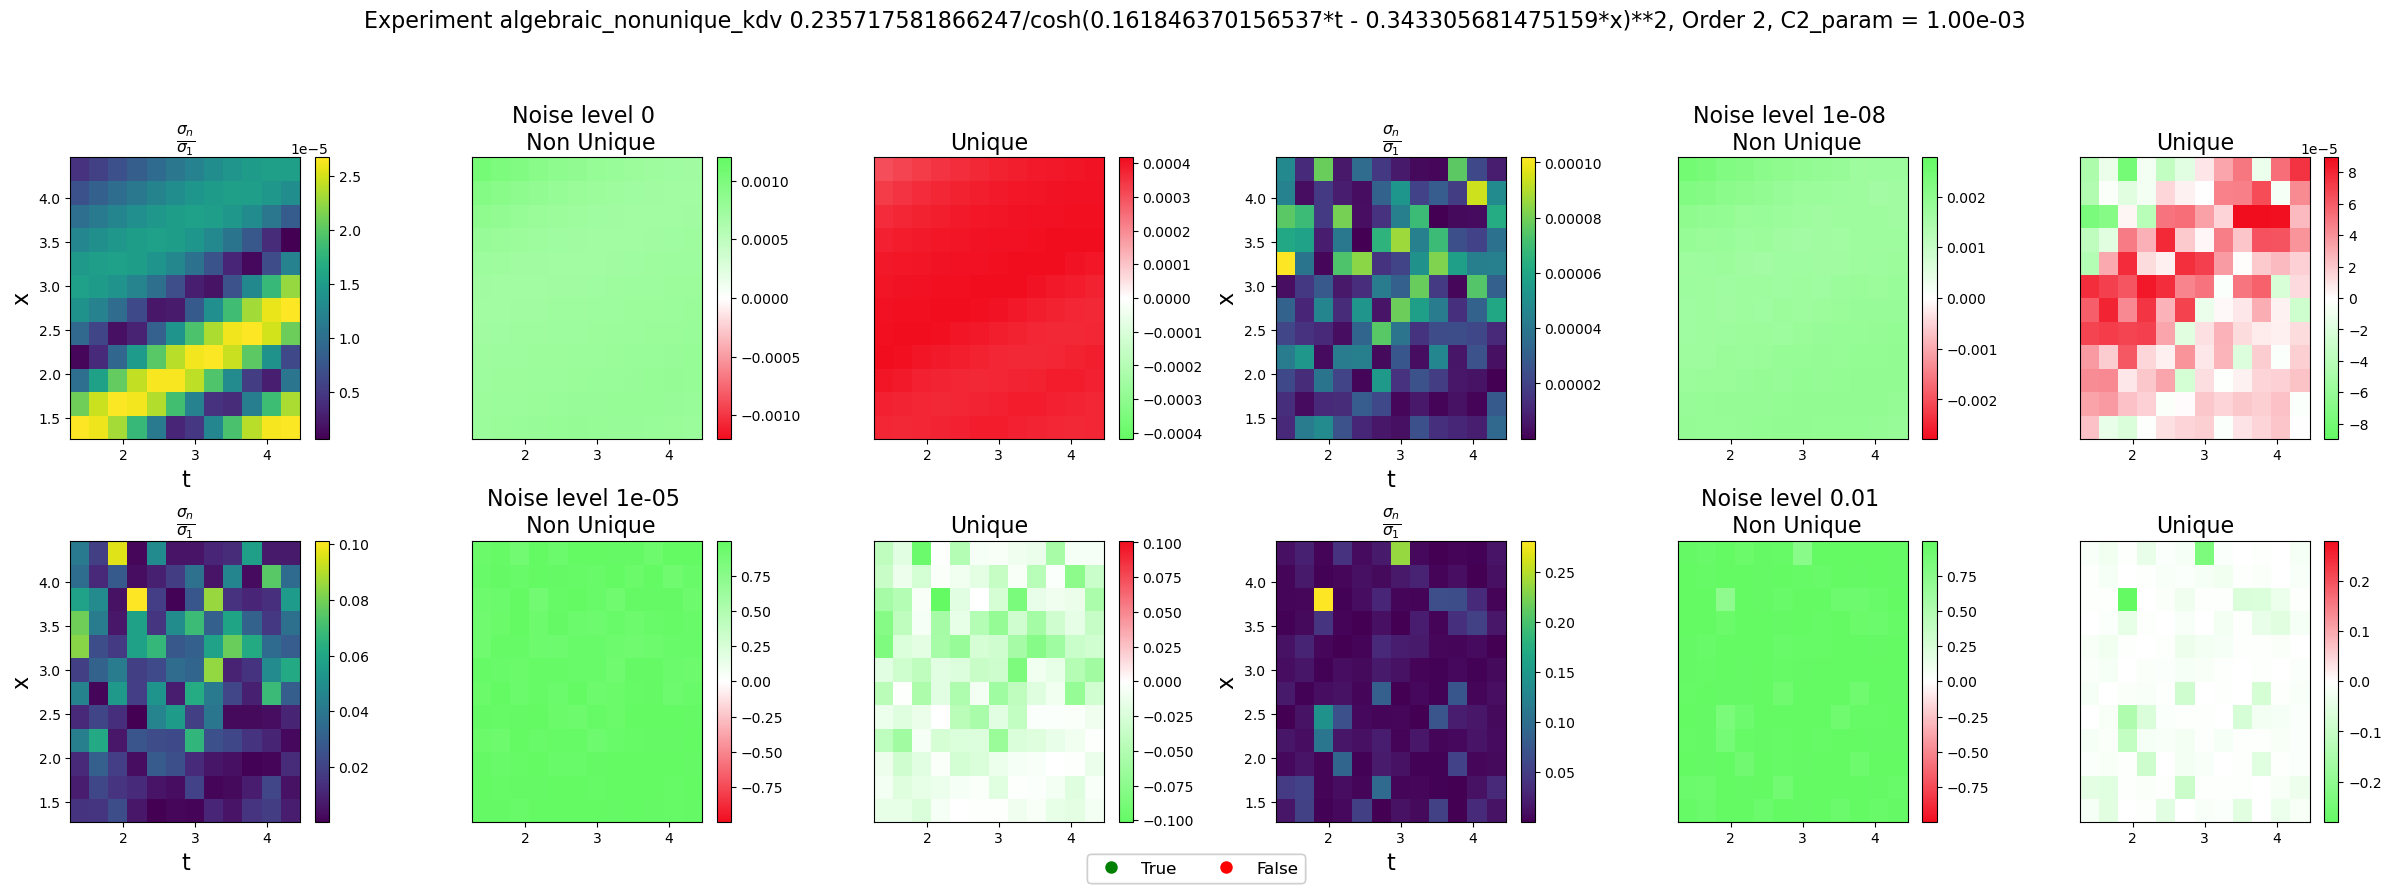

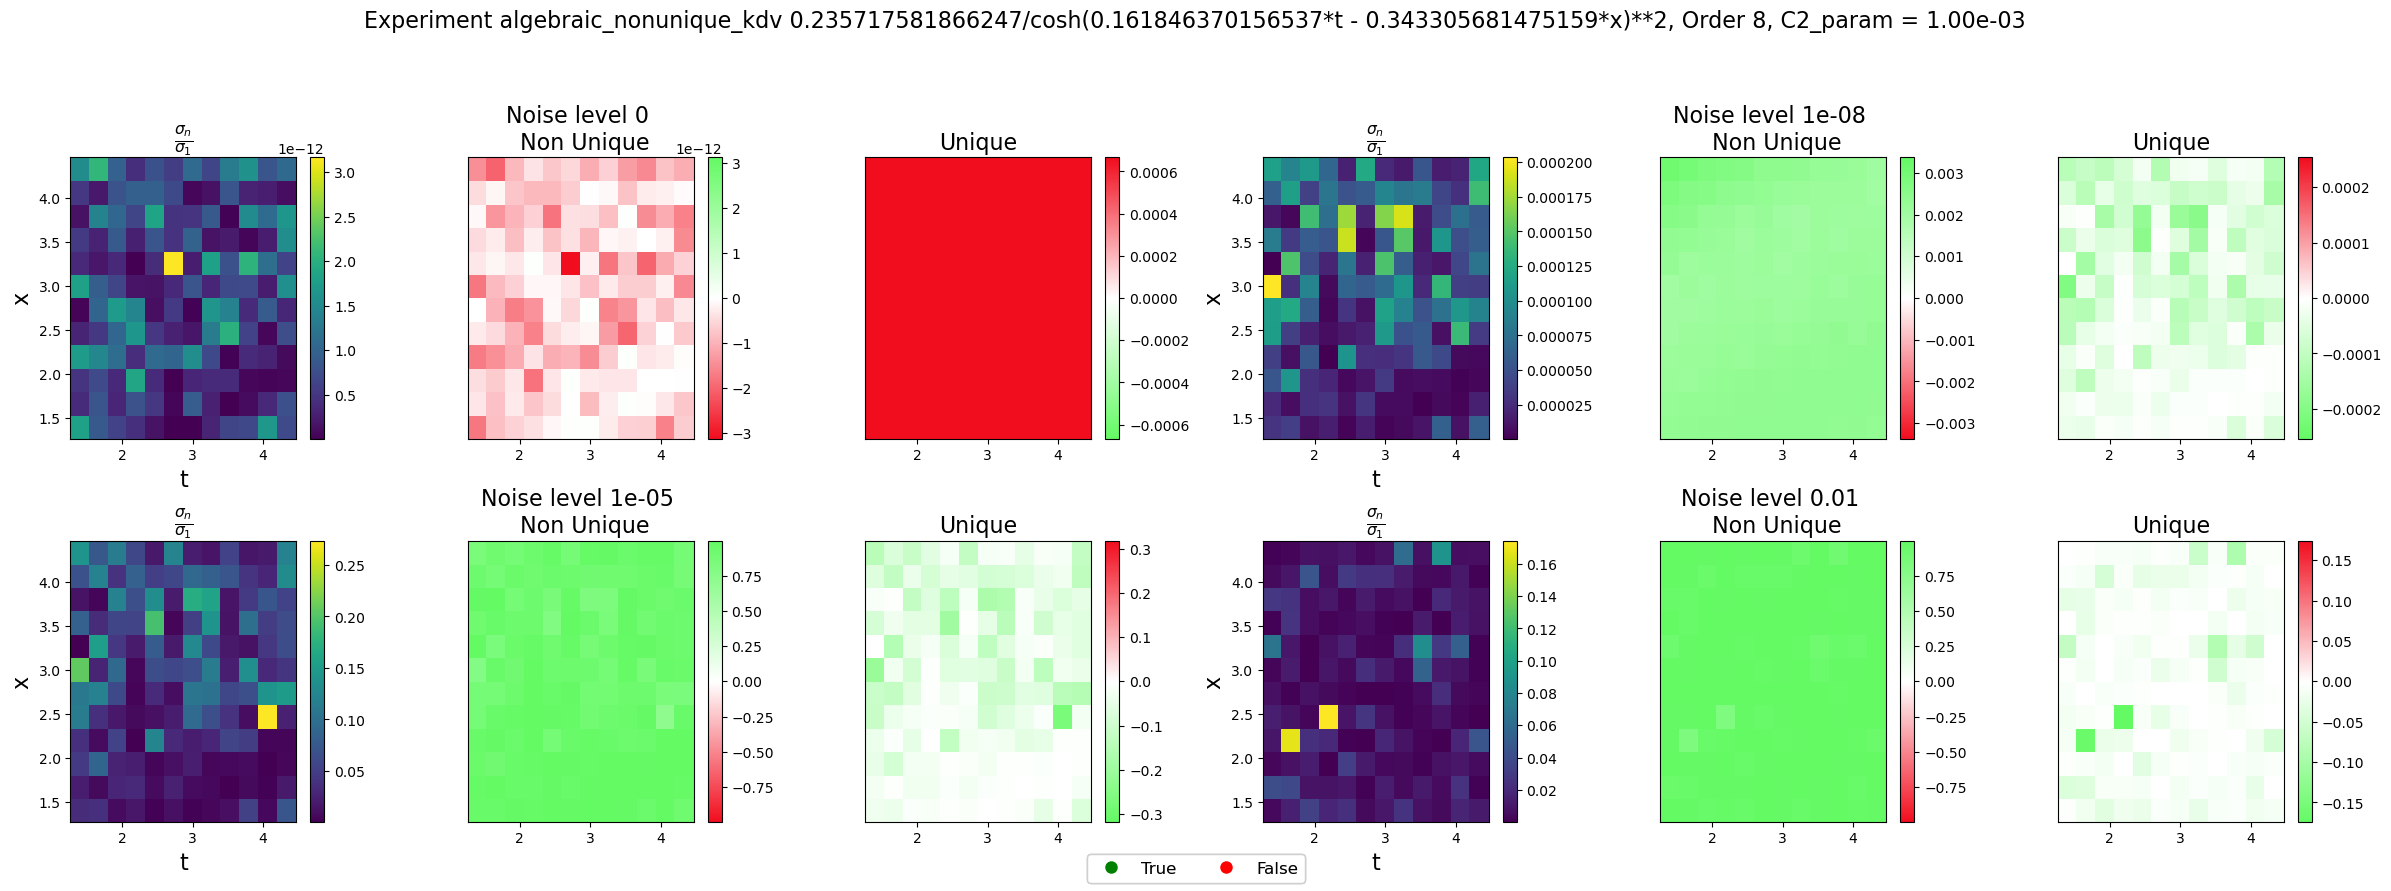

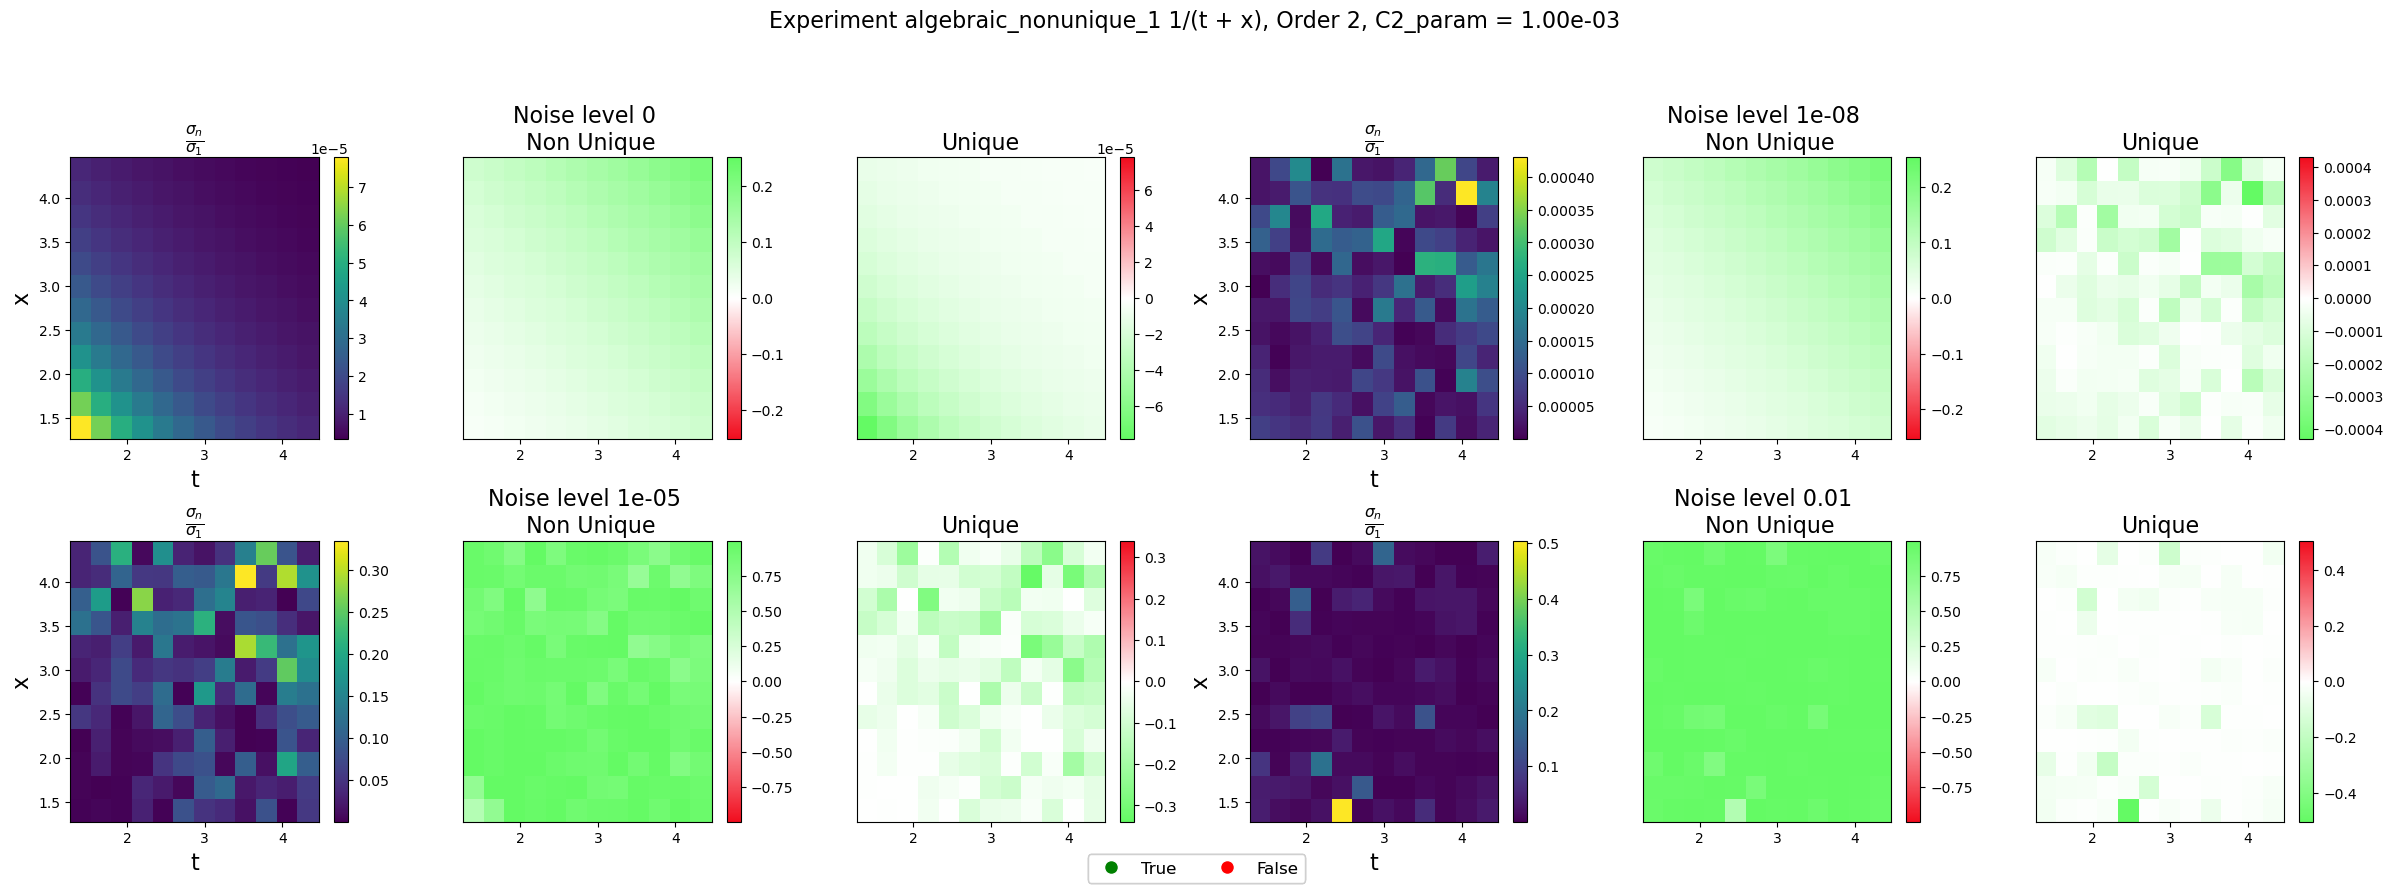

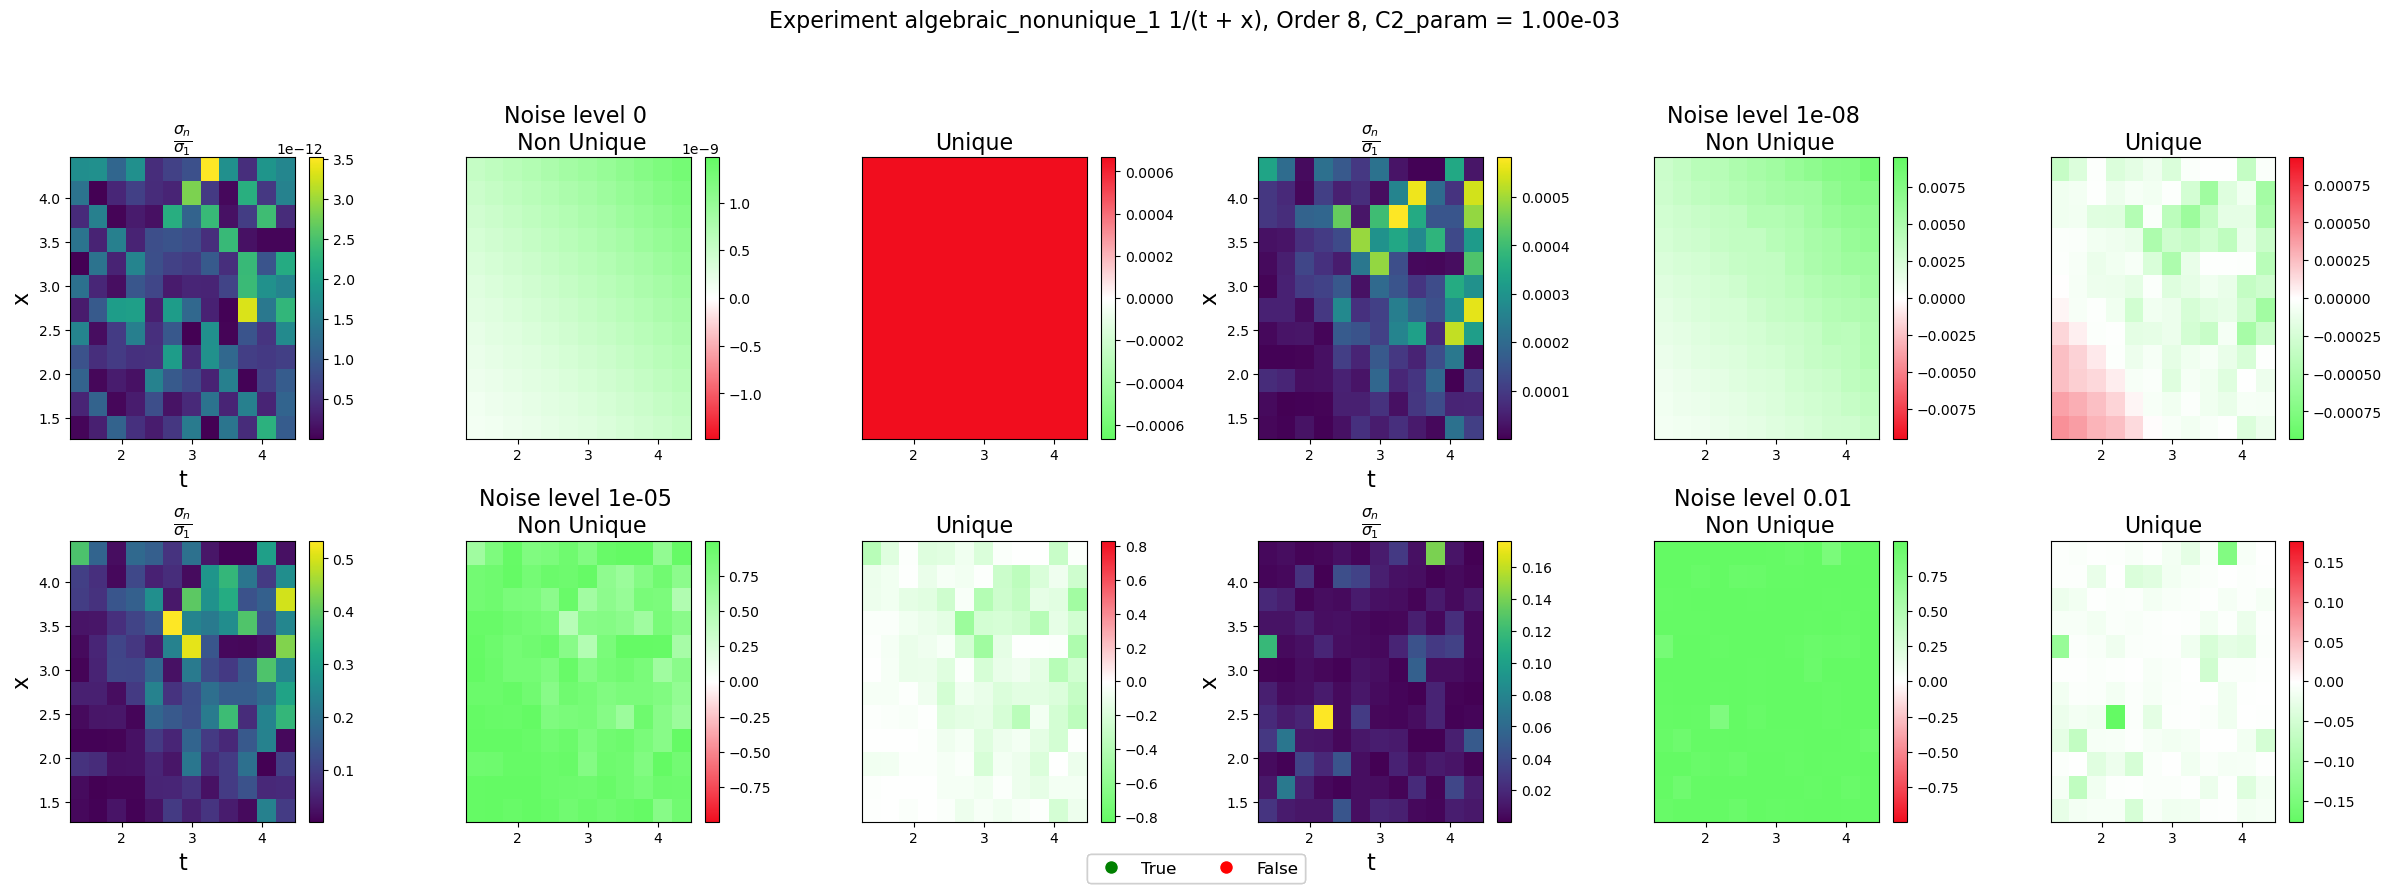

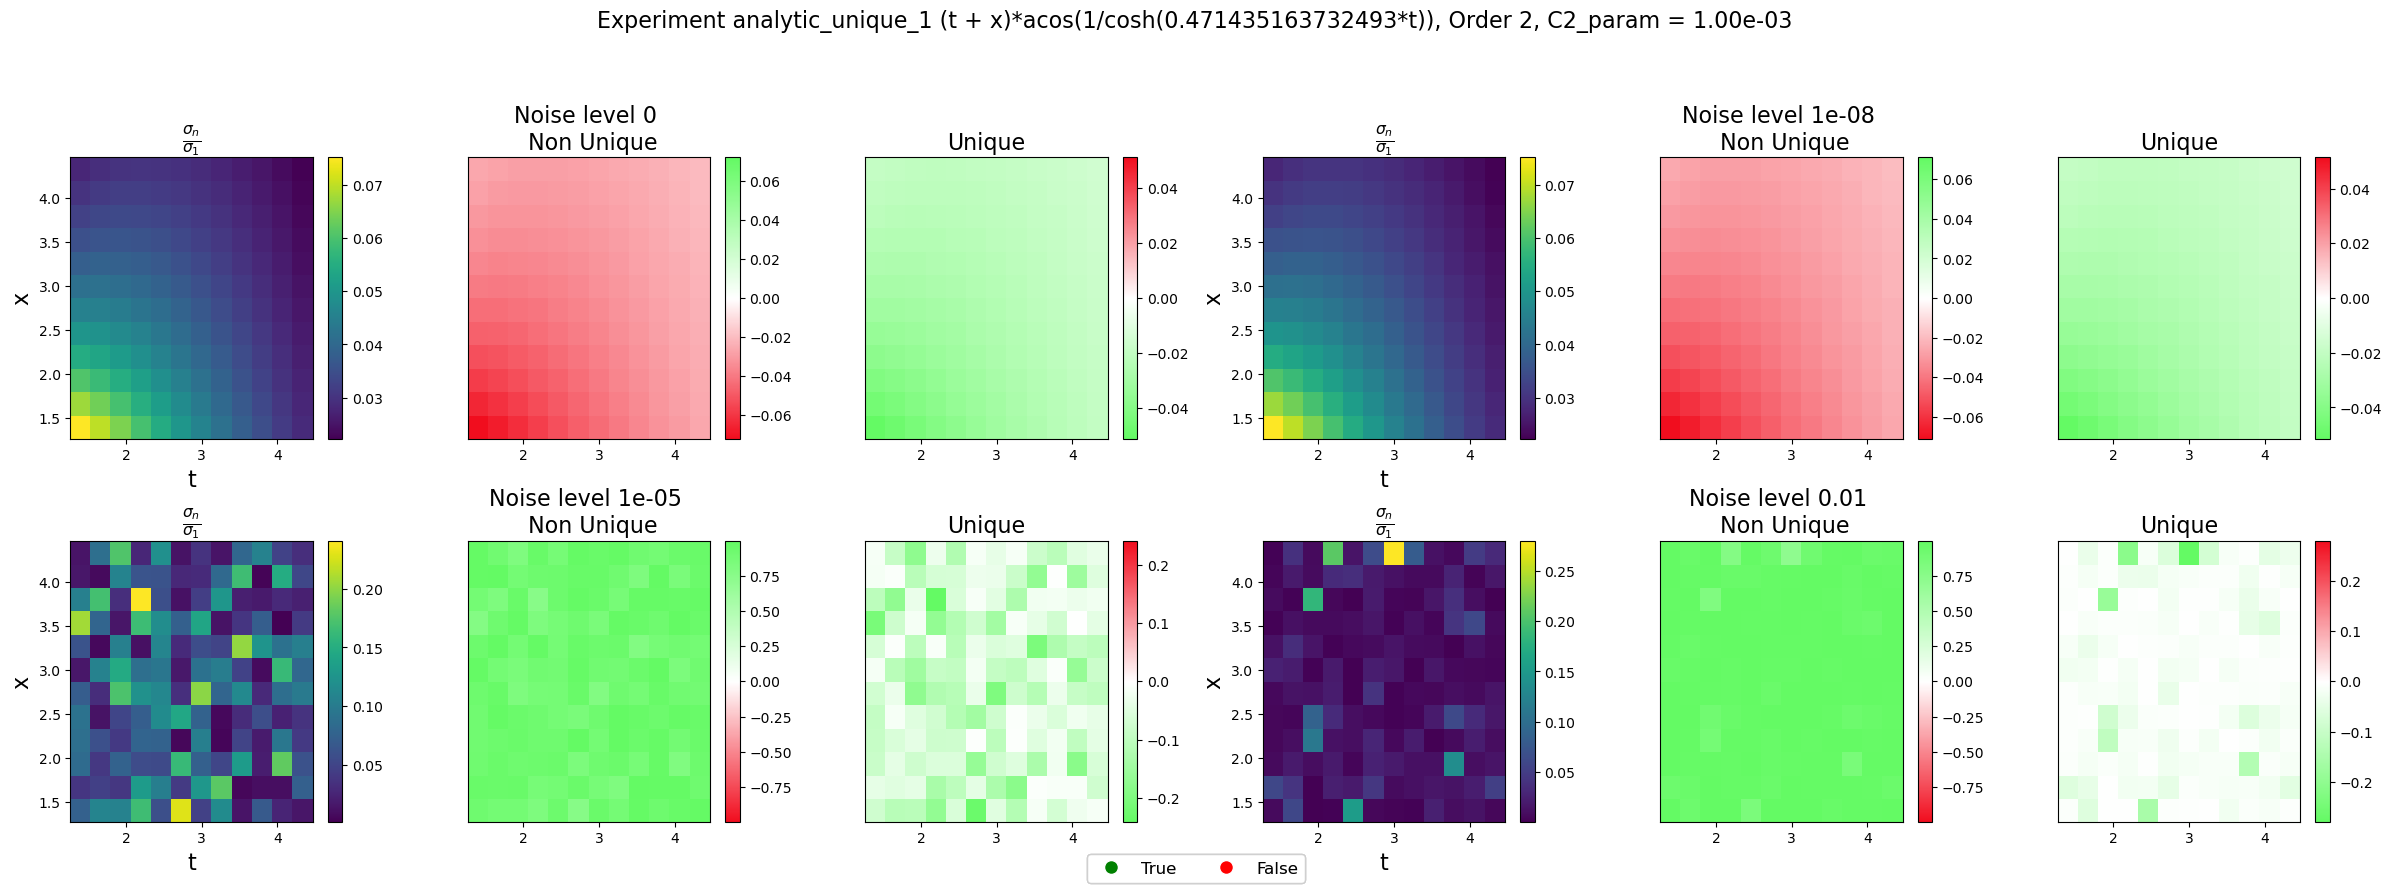

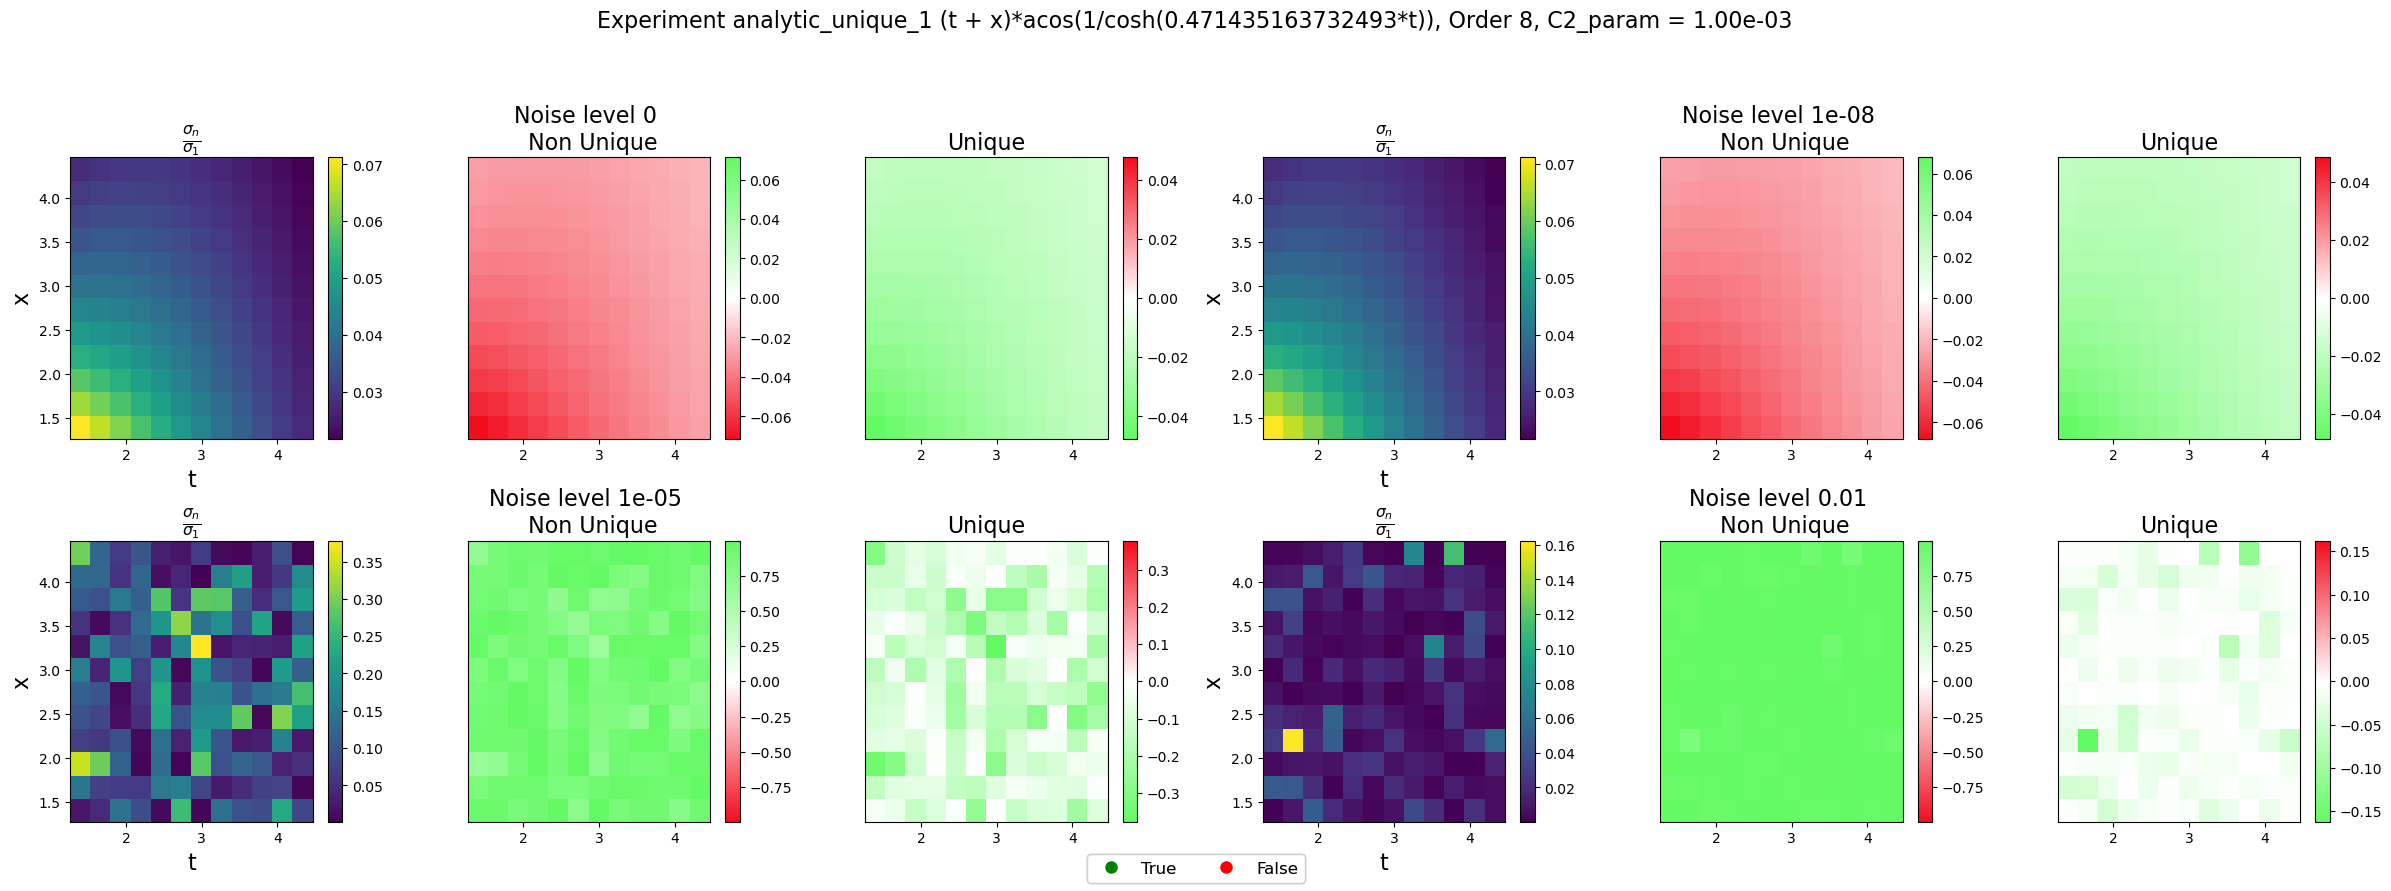

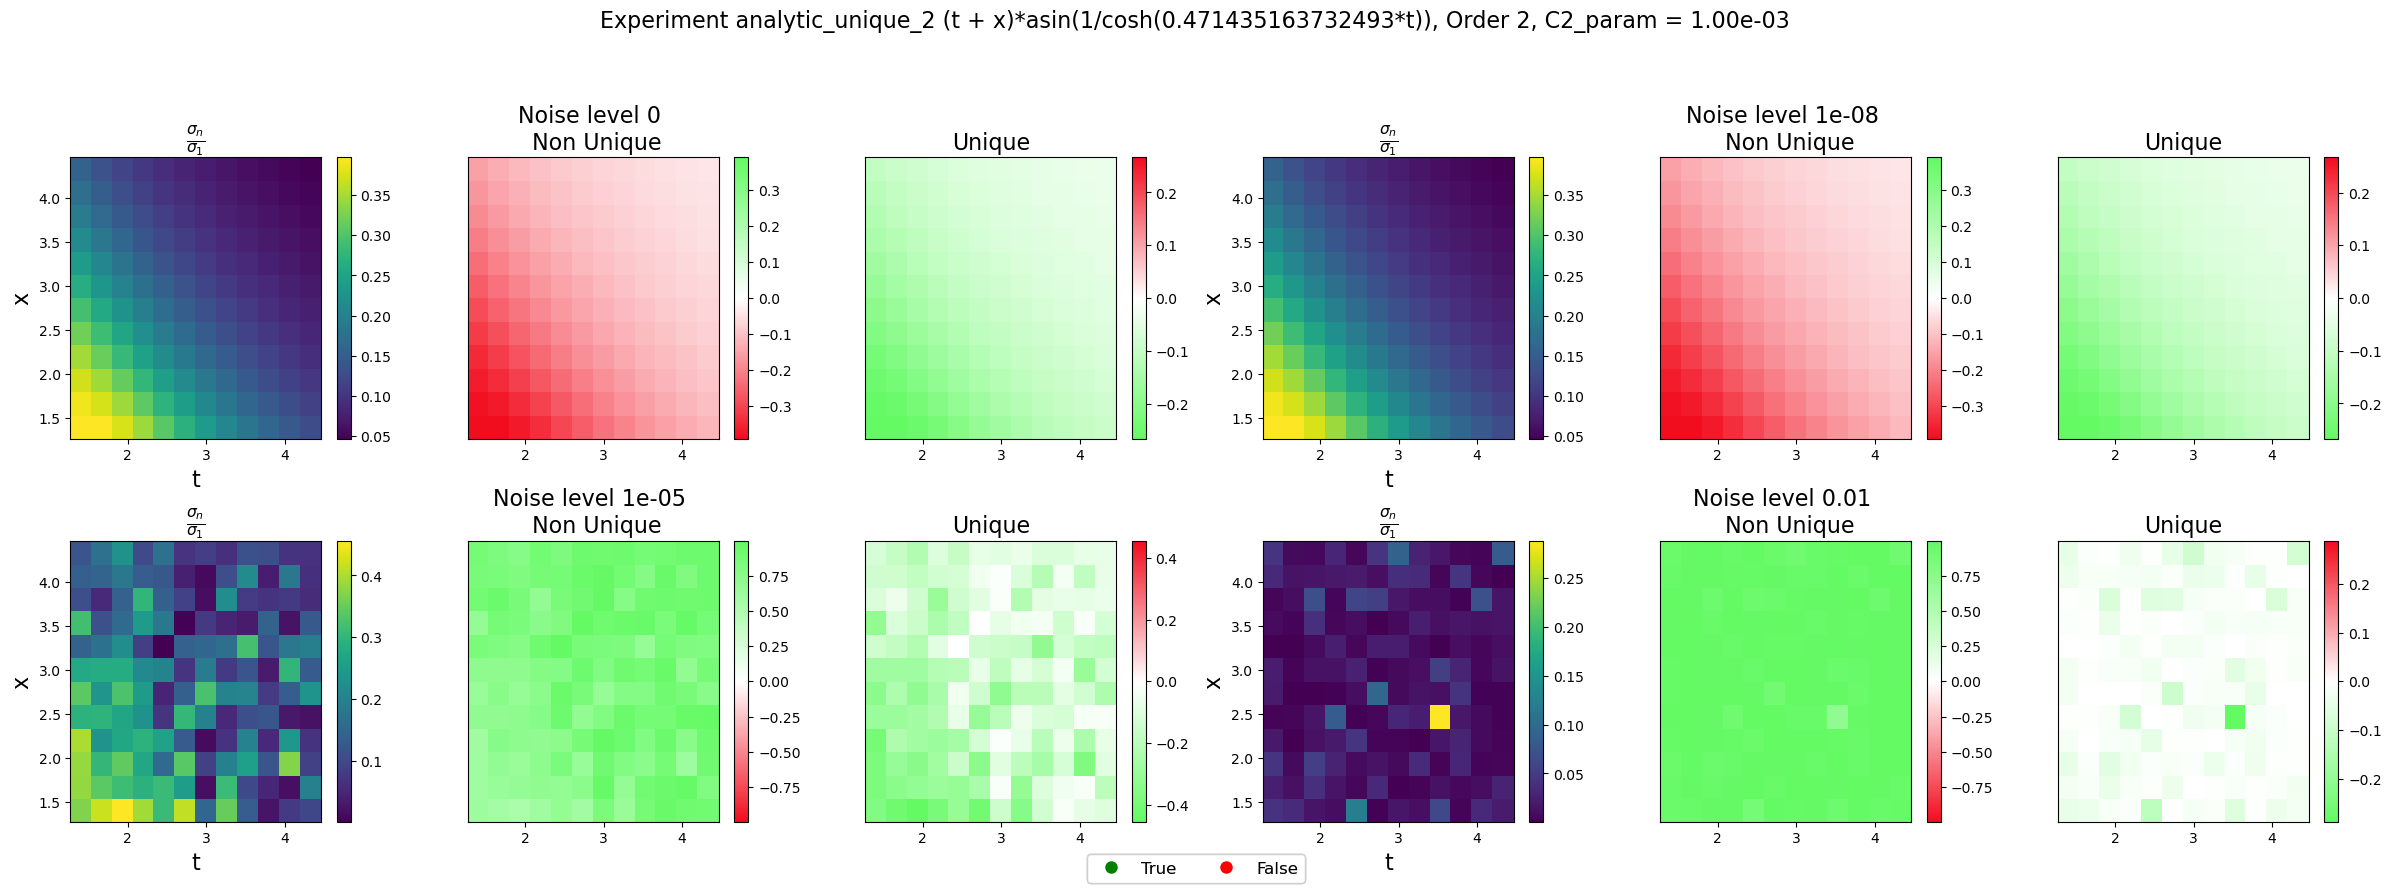

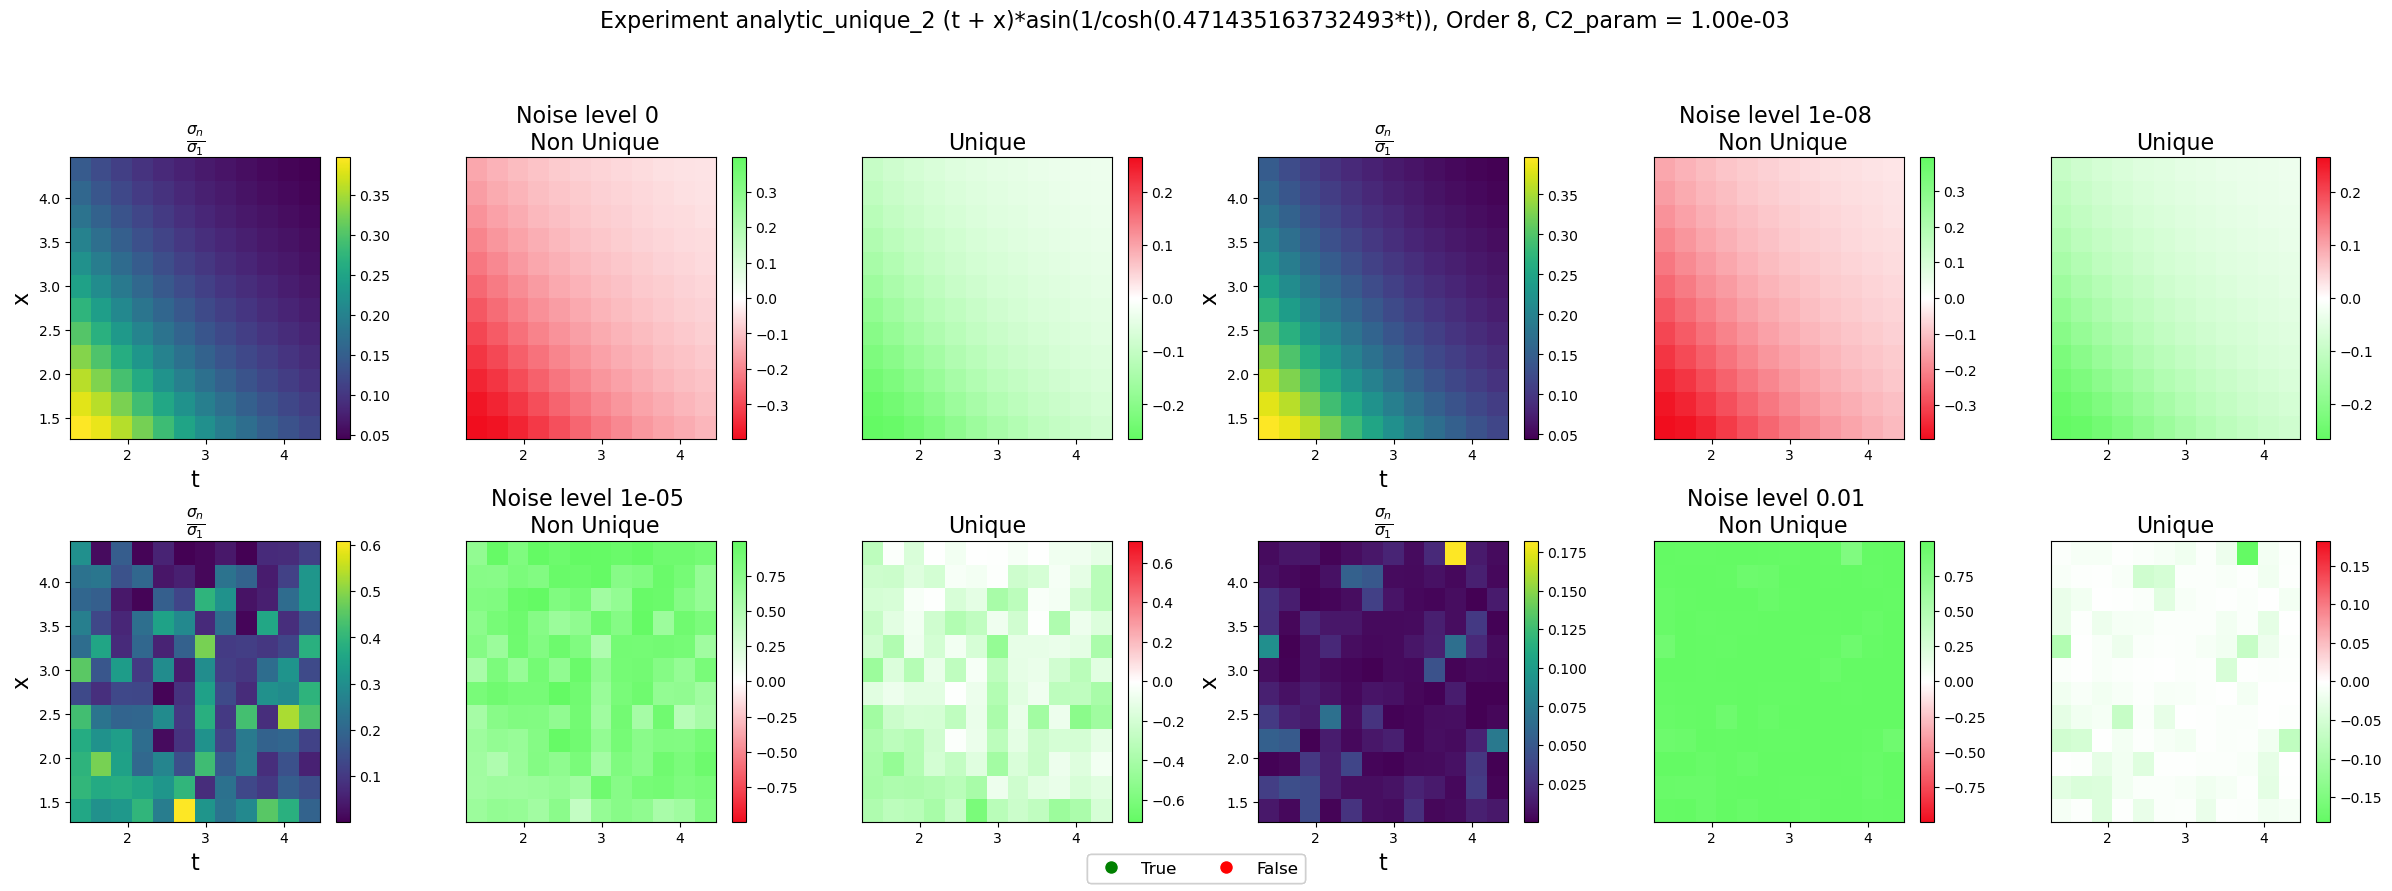

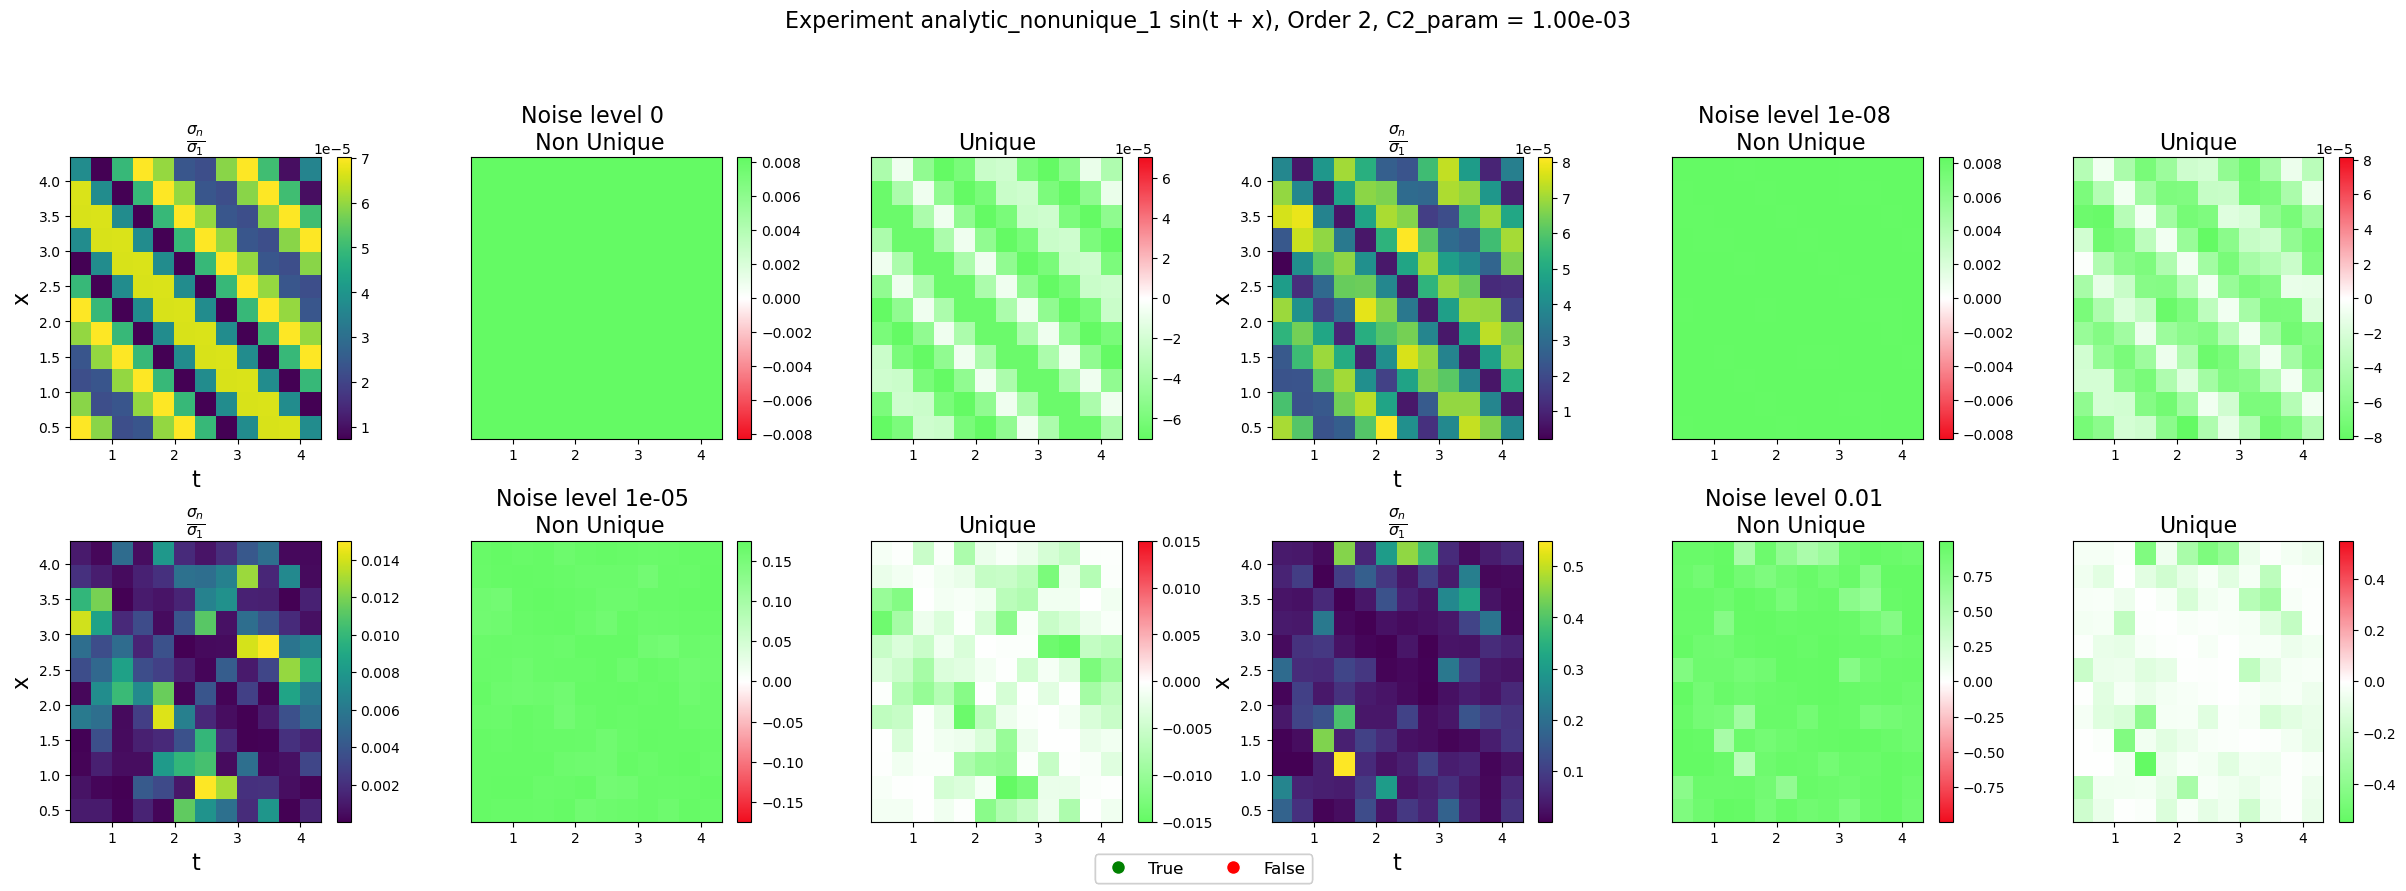

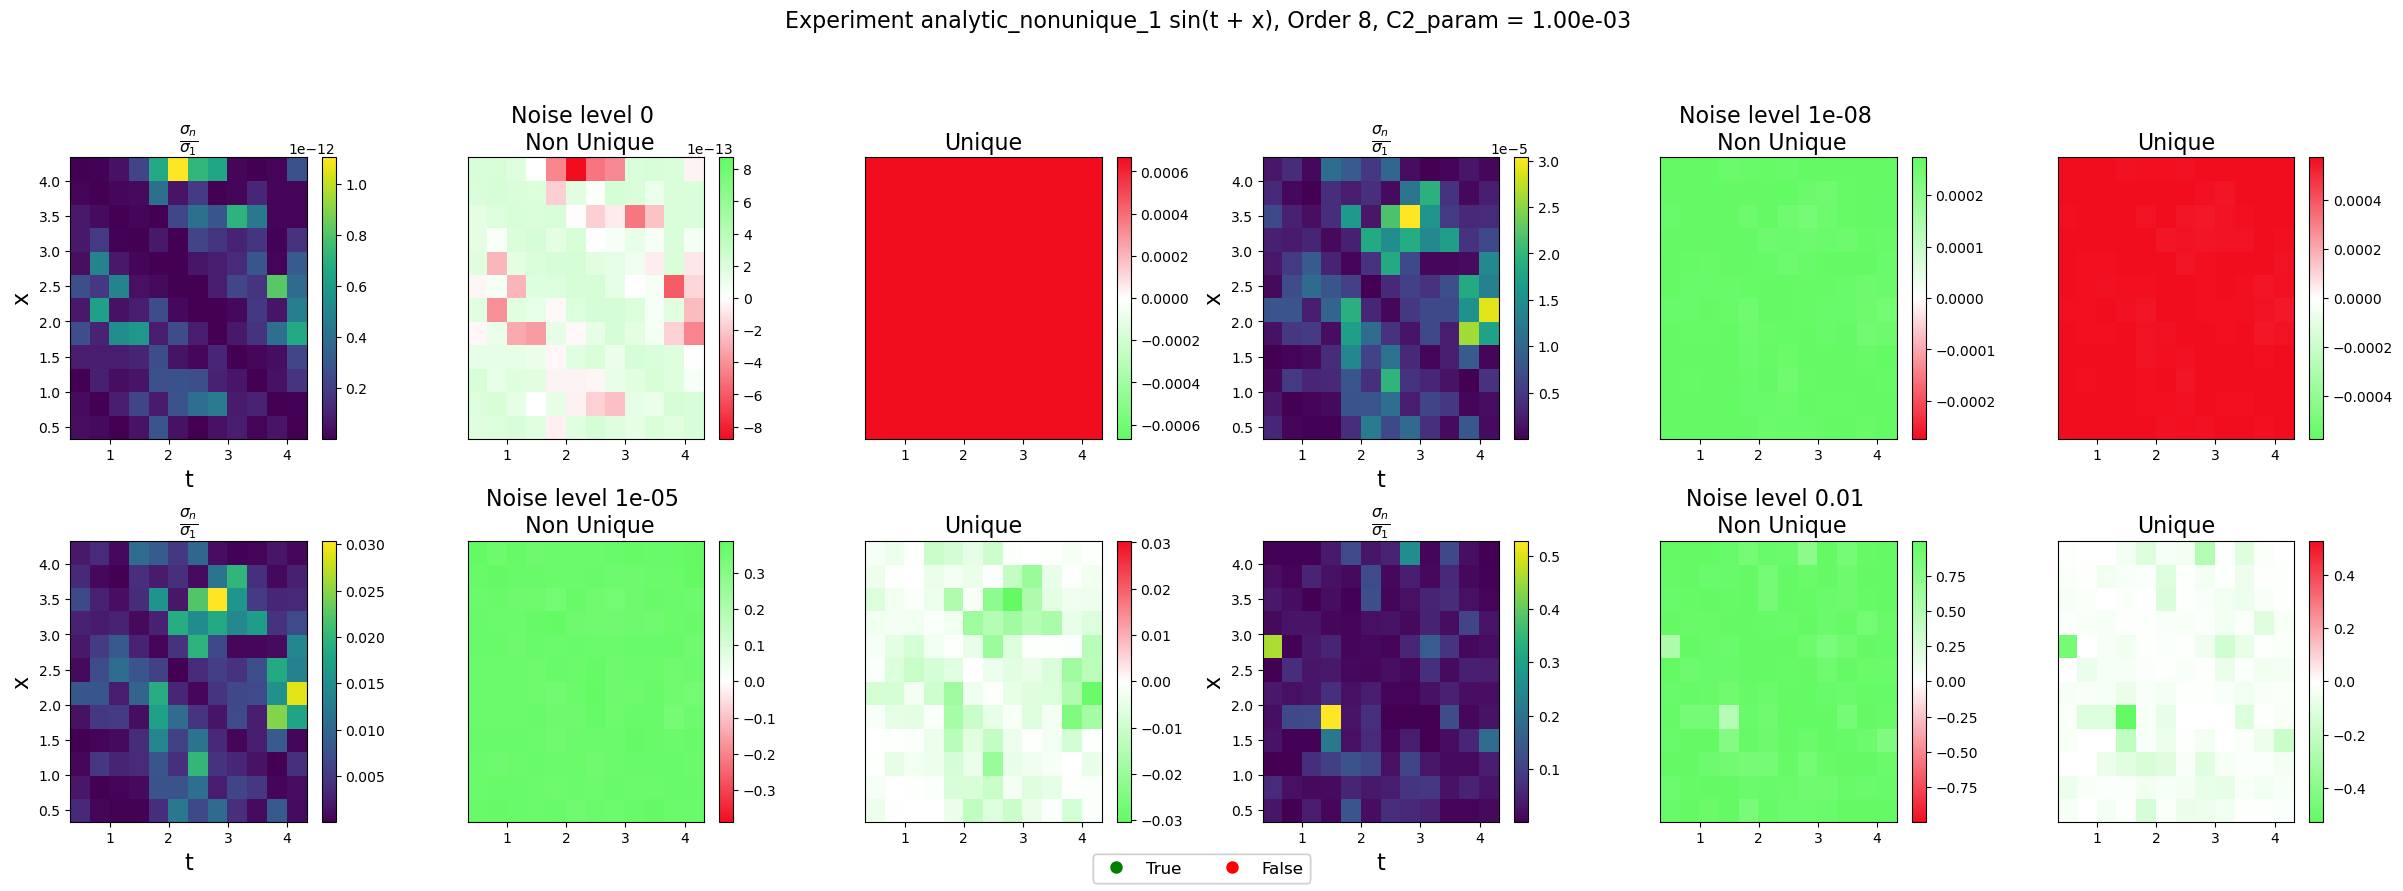

In [31]:
noise_levels = [0,1e-08,1e-05,0.01]
fd_orders=[2,8]
for experiment_name in experiment_names:
    for order in fd_orders:
        perform_experiment(noise_levels,order,experiment_name)    

### Try different C2 values for a specific example and see how it influences the result

#### Plot the pictures from before

C2 = max(1.000e+00 * sv_max,0.5*sv_min)
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 8, C2 = 1.00e+00
C2 = max(1.000e-01 * sv_max,0.5*sv_min)
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 8, C2 = 1.00e-01
C2 = max(1.000e-03 * sv_max,0.5*sv_min)
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 8, C2 = 1.00e-03
C2 = max(1.000e-04 * sv_max,0.5*sv_min)
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 8, C2 = 1.00e-04
C2 = max(1.000e-05 * sv_max,0.5*sv_min)
Performing experiment algebraic_nonunique_kdv 0.235717581866247/cosh(0.161846370156537*t - 0.343305681475159*x)**2 with order 8, C2 = 1.00e-05
C2 = max(1.000e-06 * sv_max,0.5*sv_min)
Performing experiment algebraic_nonunique_kdv

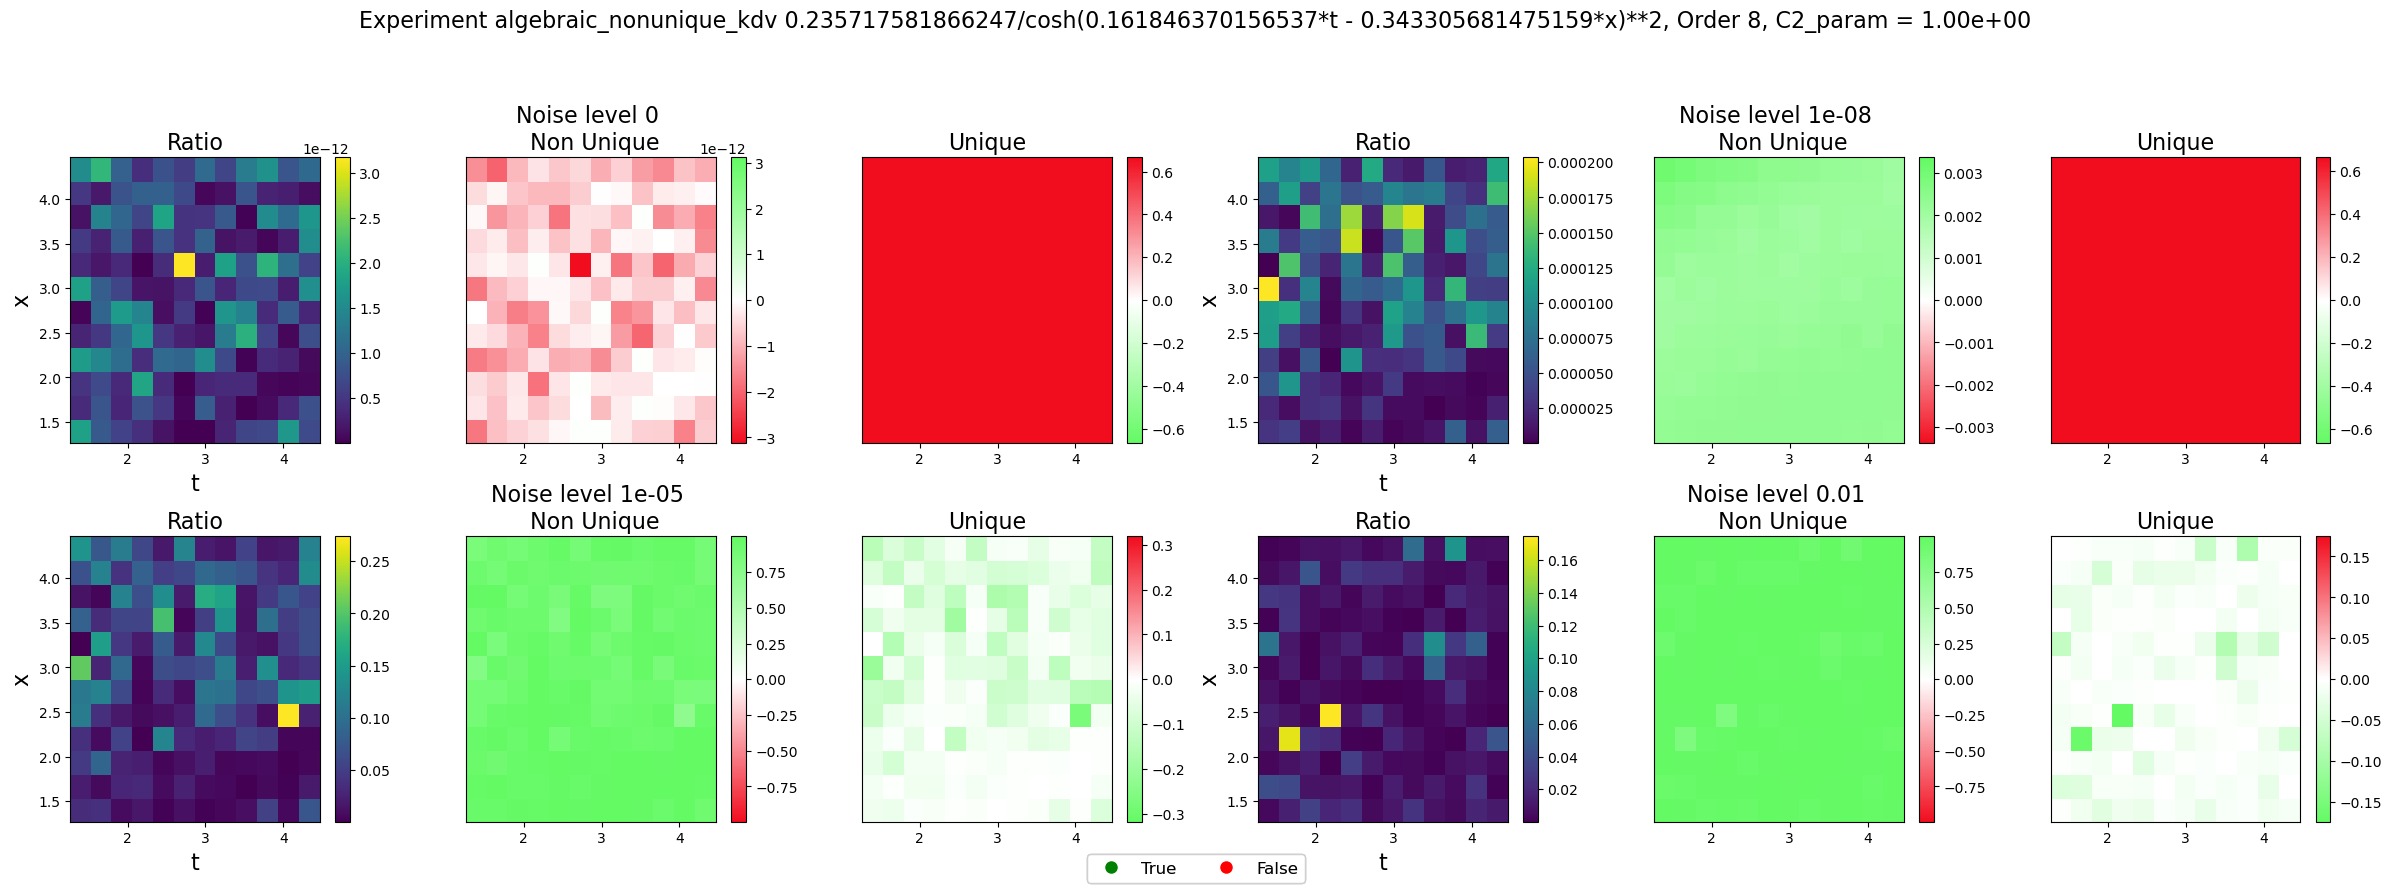

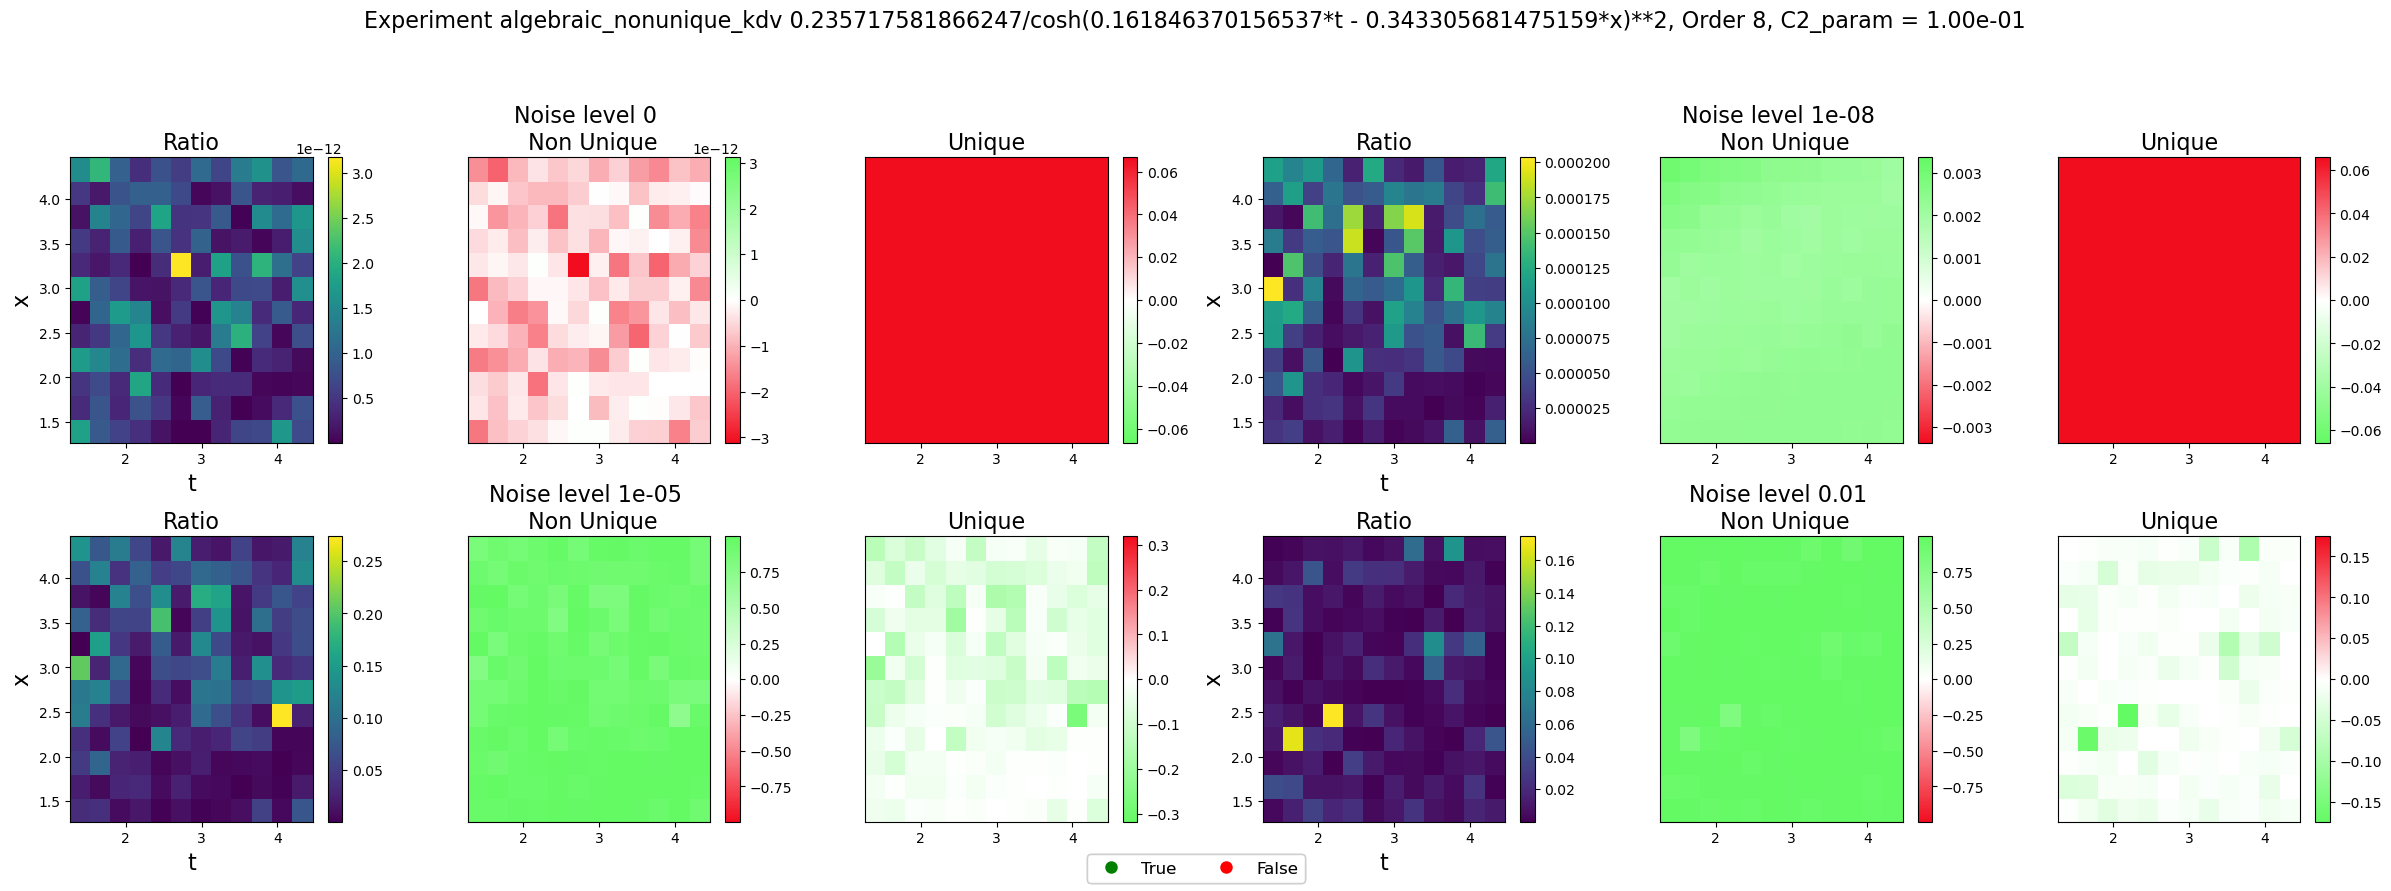

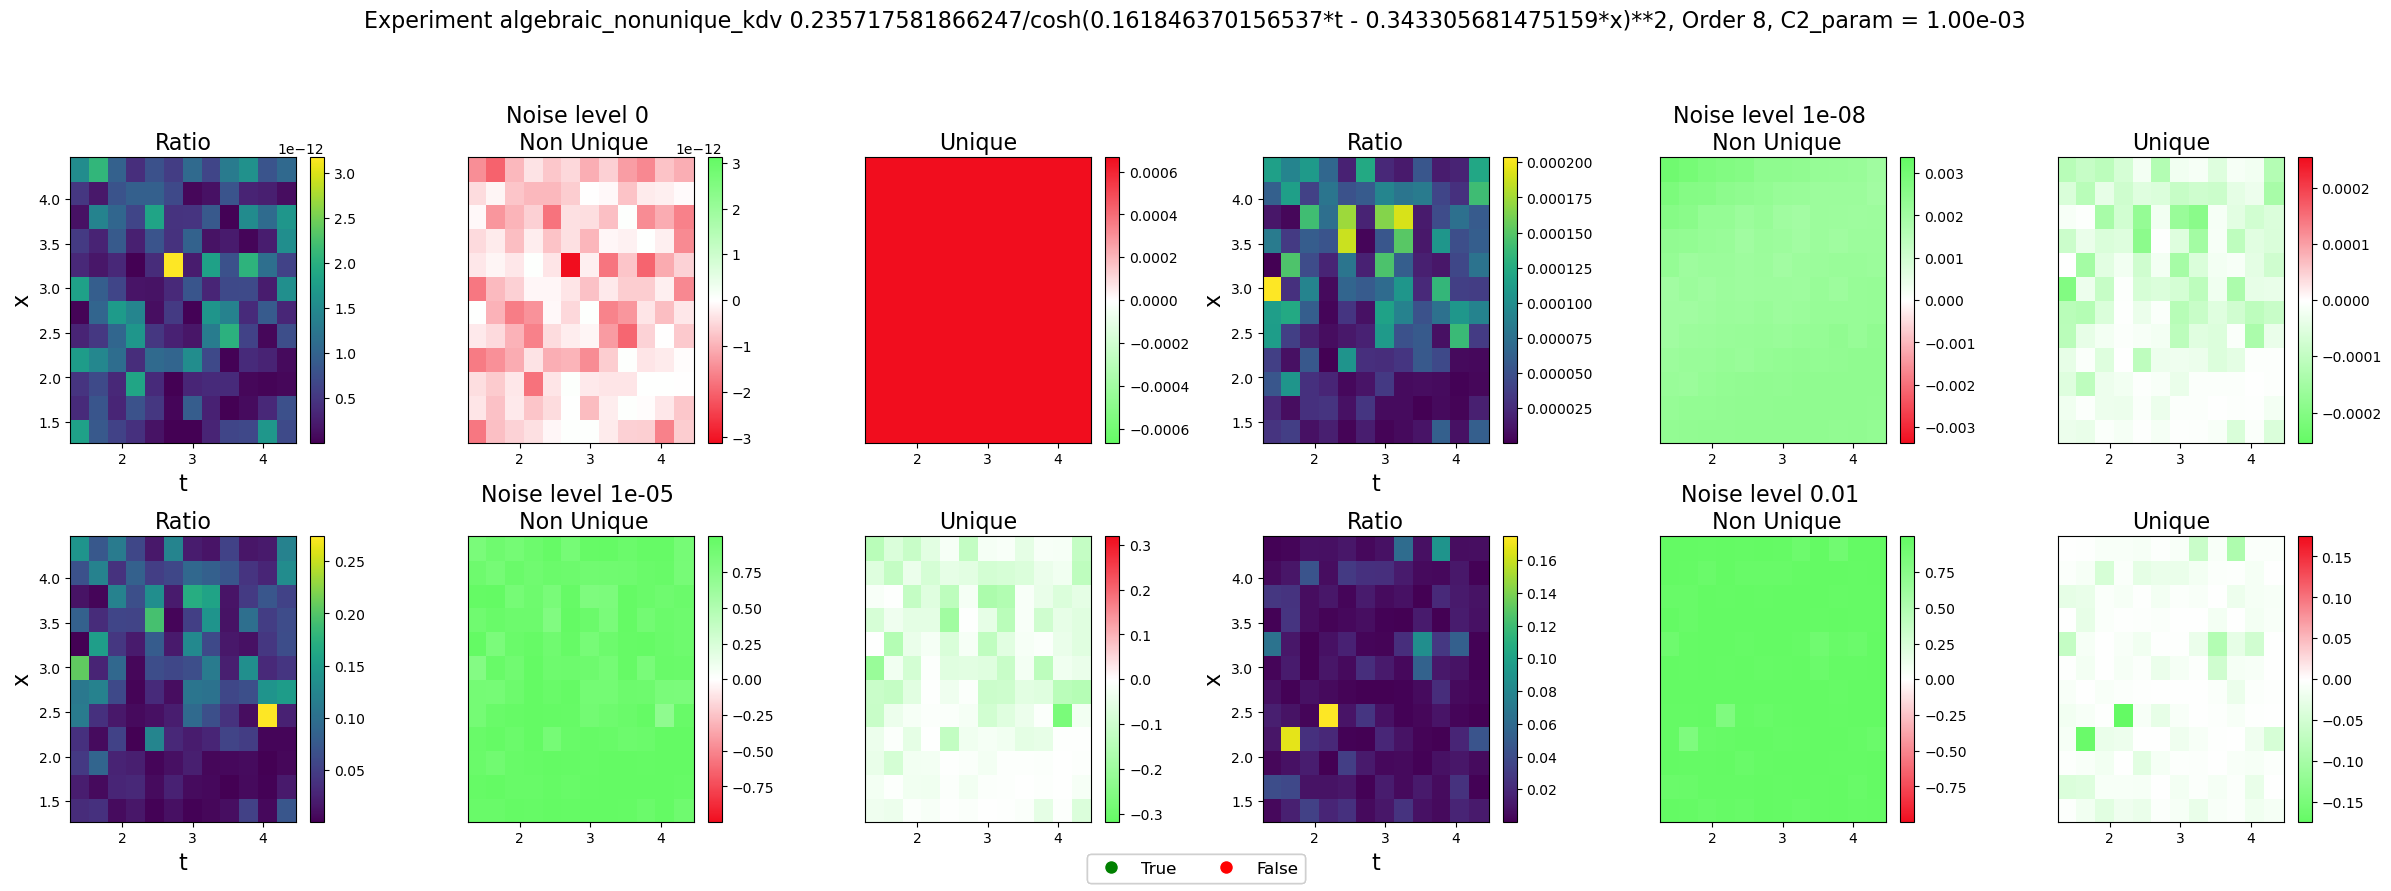

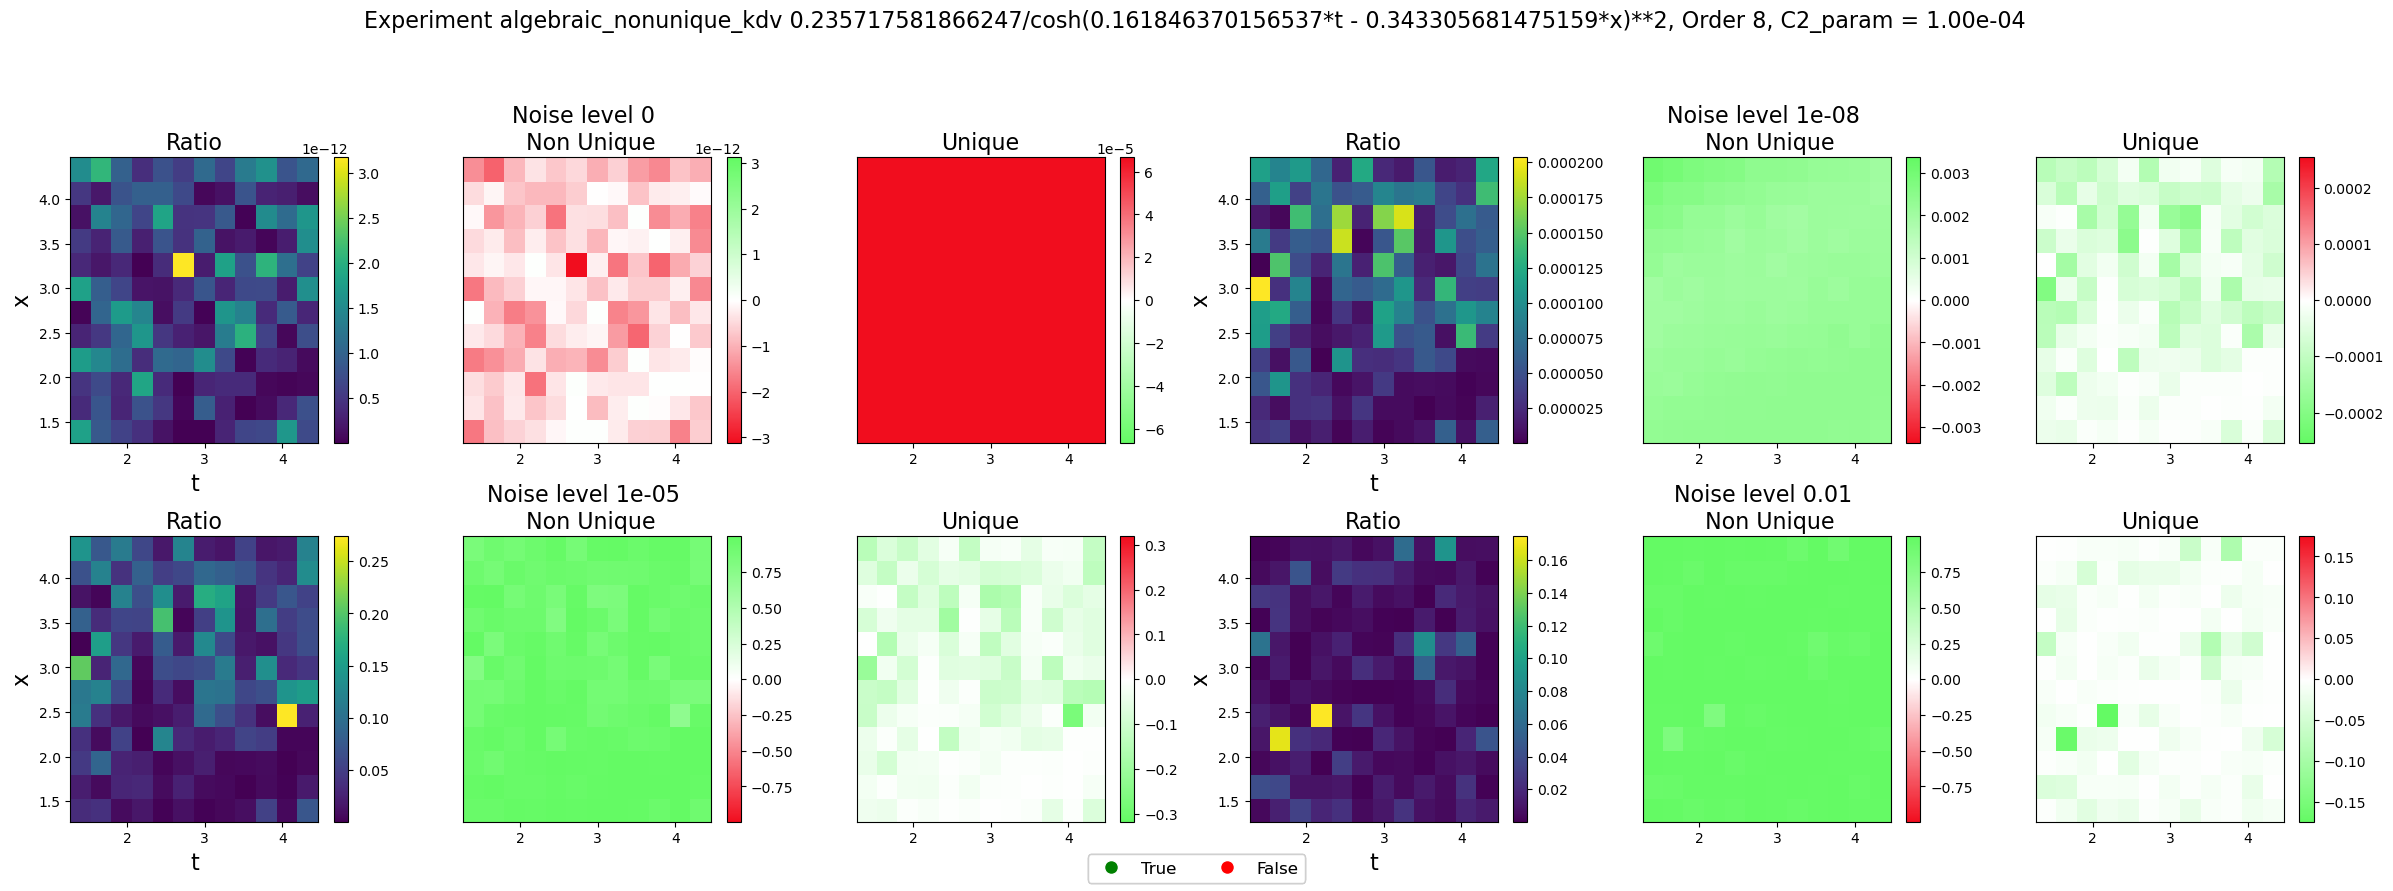

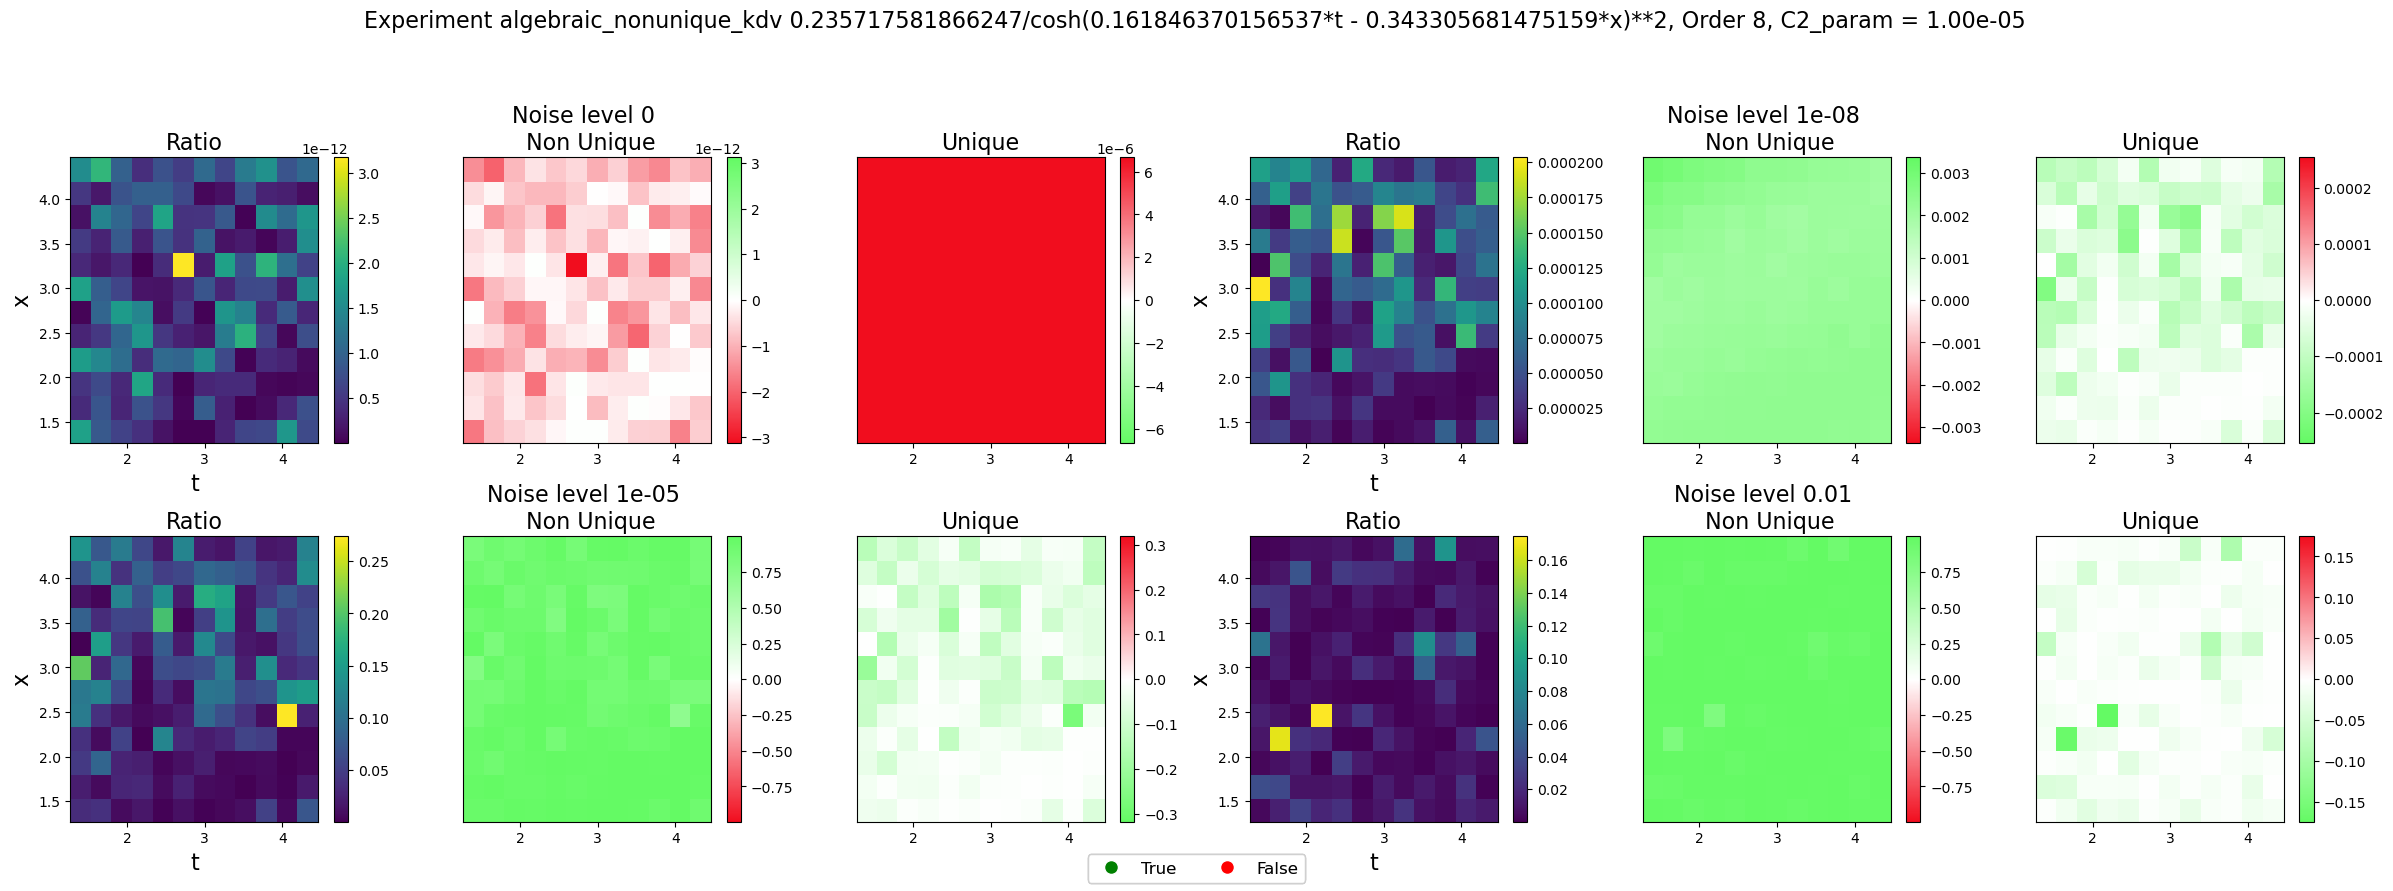

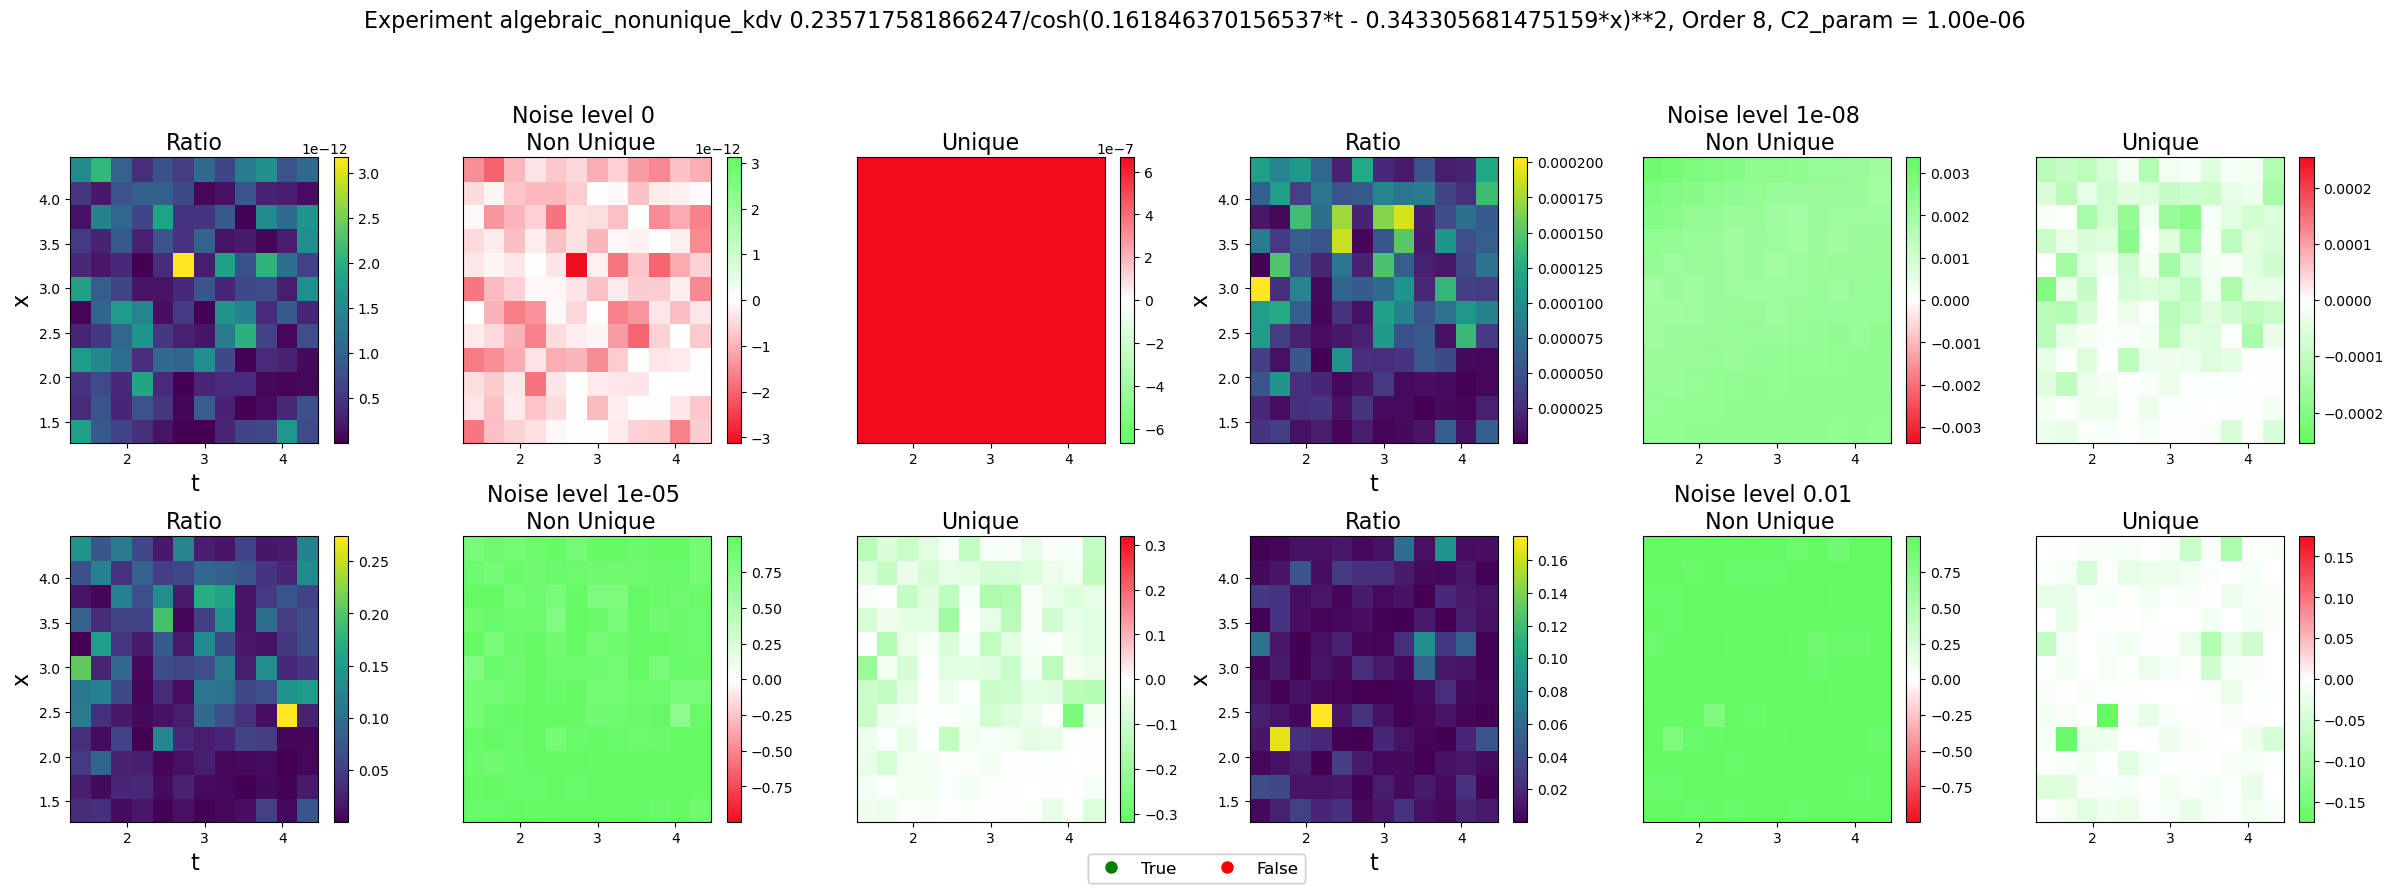

In [26]:
# Non unique example
experiment_name = experiment_names[0]
fd_orders=[8]
C2_params=[1.0,1e-1,1e-3,1e-4,1e-5,1e-6]
for C2_param in C2_params:
    print(f"C2 = max({C2_param:.3e} * sv_max,0.5*sv_min)")
    perform_experiment(noise_levels,order,experiment_name,C2_param)    

C2 = max(1.000e+00 * sv_max,0.5*sv_min)
Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.471435163732493*t)) with order 8, C2 = 1.00e+00
C2 = max(1.000e-01 * sv_max,0.5*sv_min)
Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.471435163732493*t)) with order 8, C2 = 1.00e-01
C2 = max(1.000e-03 * sv_max,0.5*sv_min)
Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.471435163732493*t)) with order 8, C2 = 1.00e-03
C2 = max(1.000e-04 * sv_max,0.5*sv_min)
Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.471435163732493*t)) with order 8, C2 = 1.00e-04
C2 = max(1.000e-05 * sv_max,0.5*sv_min)
Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.471435163732493*t)) with order 8, C2 = 1.00e-05
C2 = max(1.000e-06 * sv_max,0.5*sv_min)
Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.471435163732493*t)) with order 8, C2 = 1.00e-06


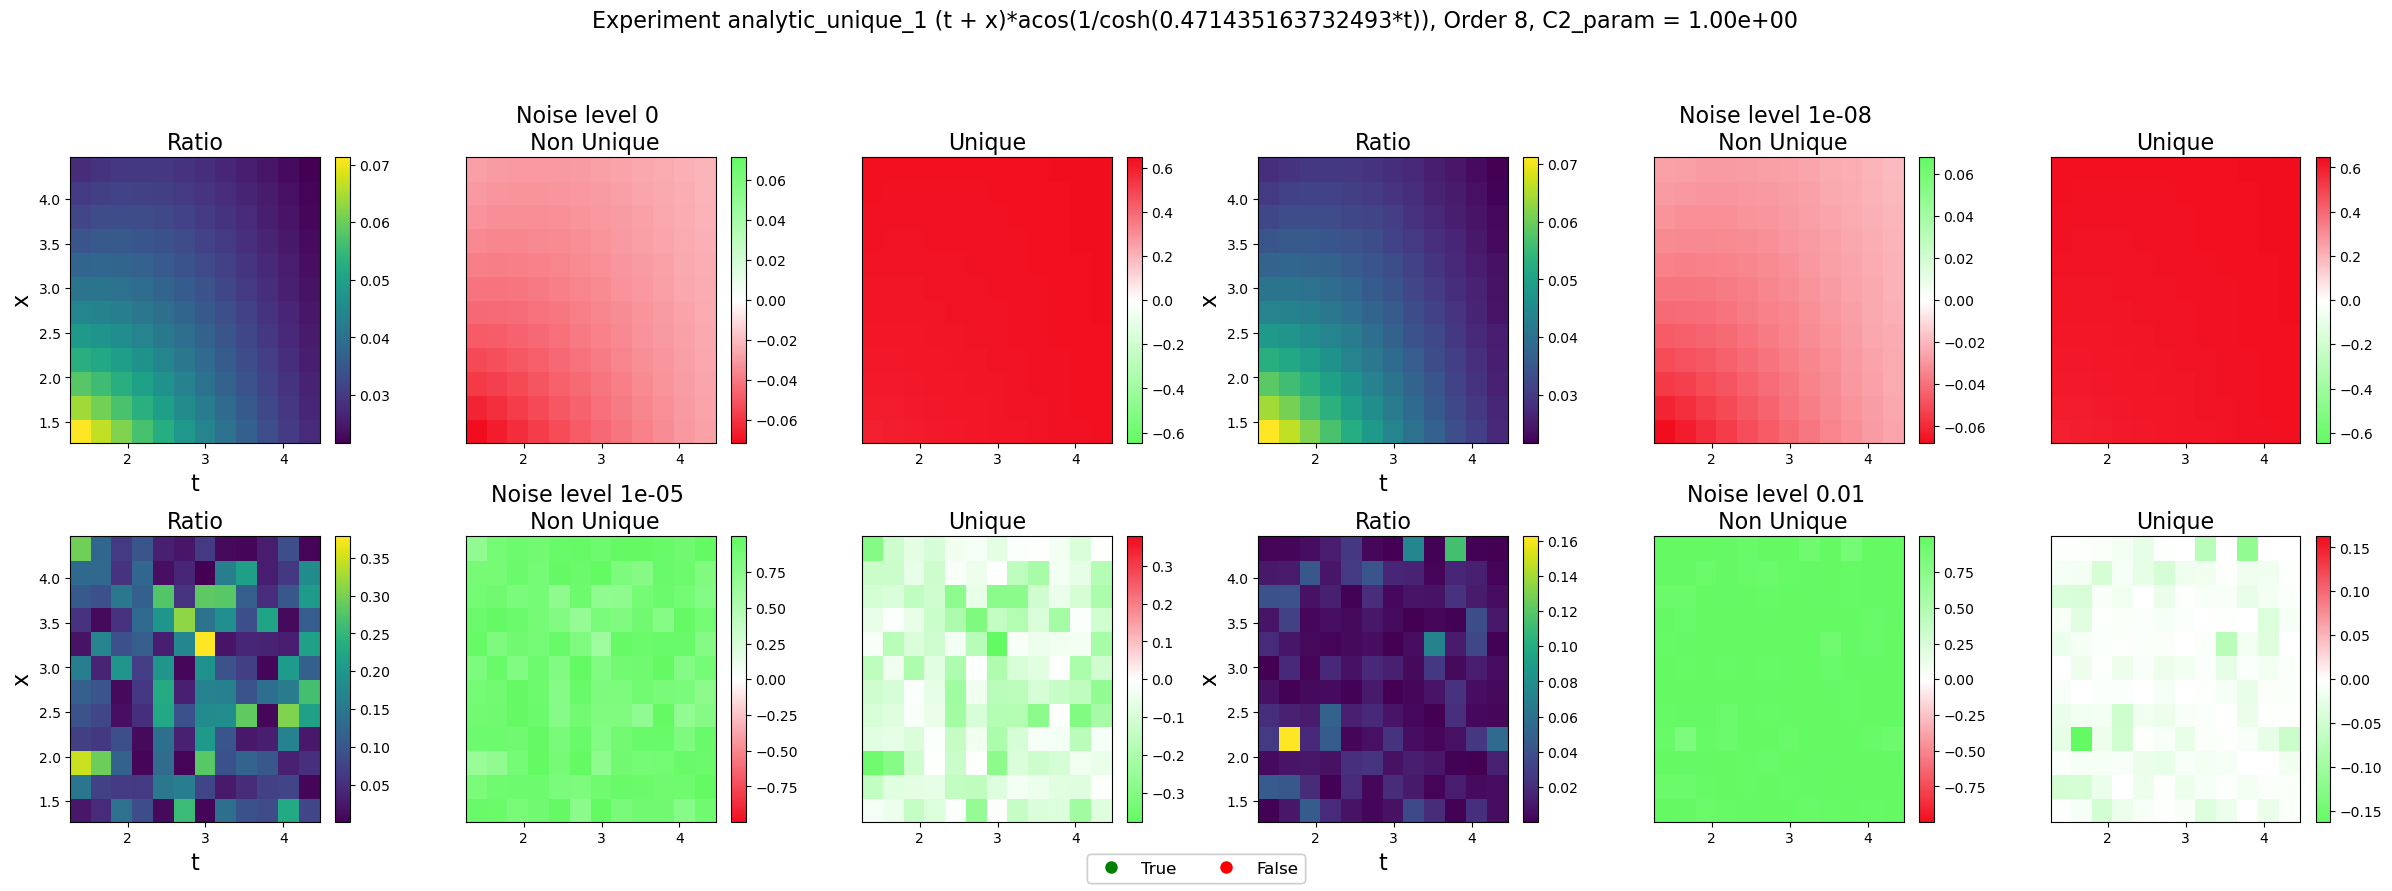

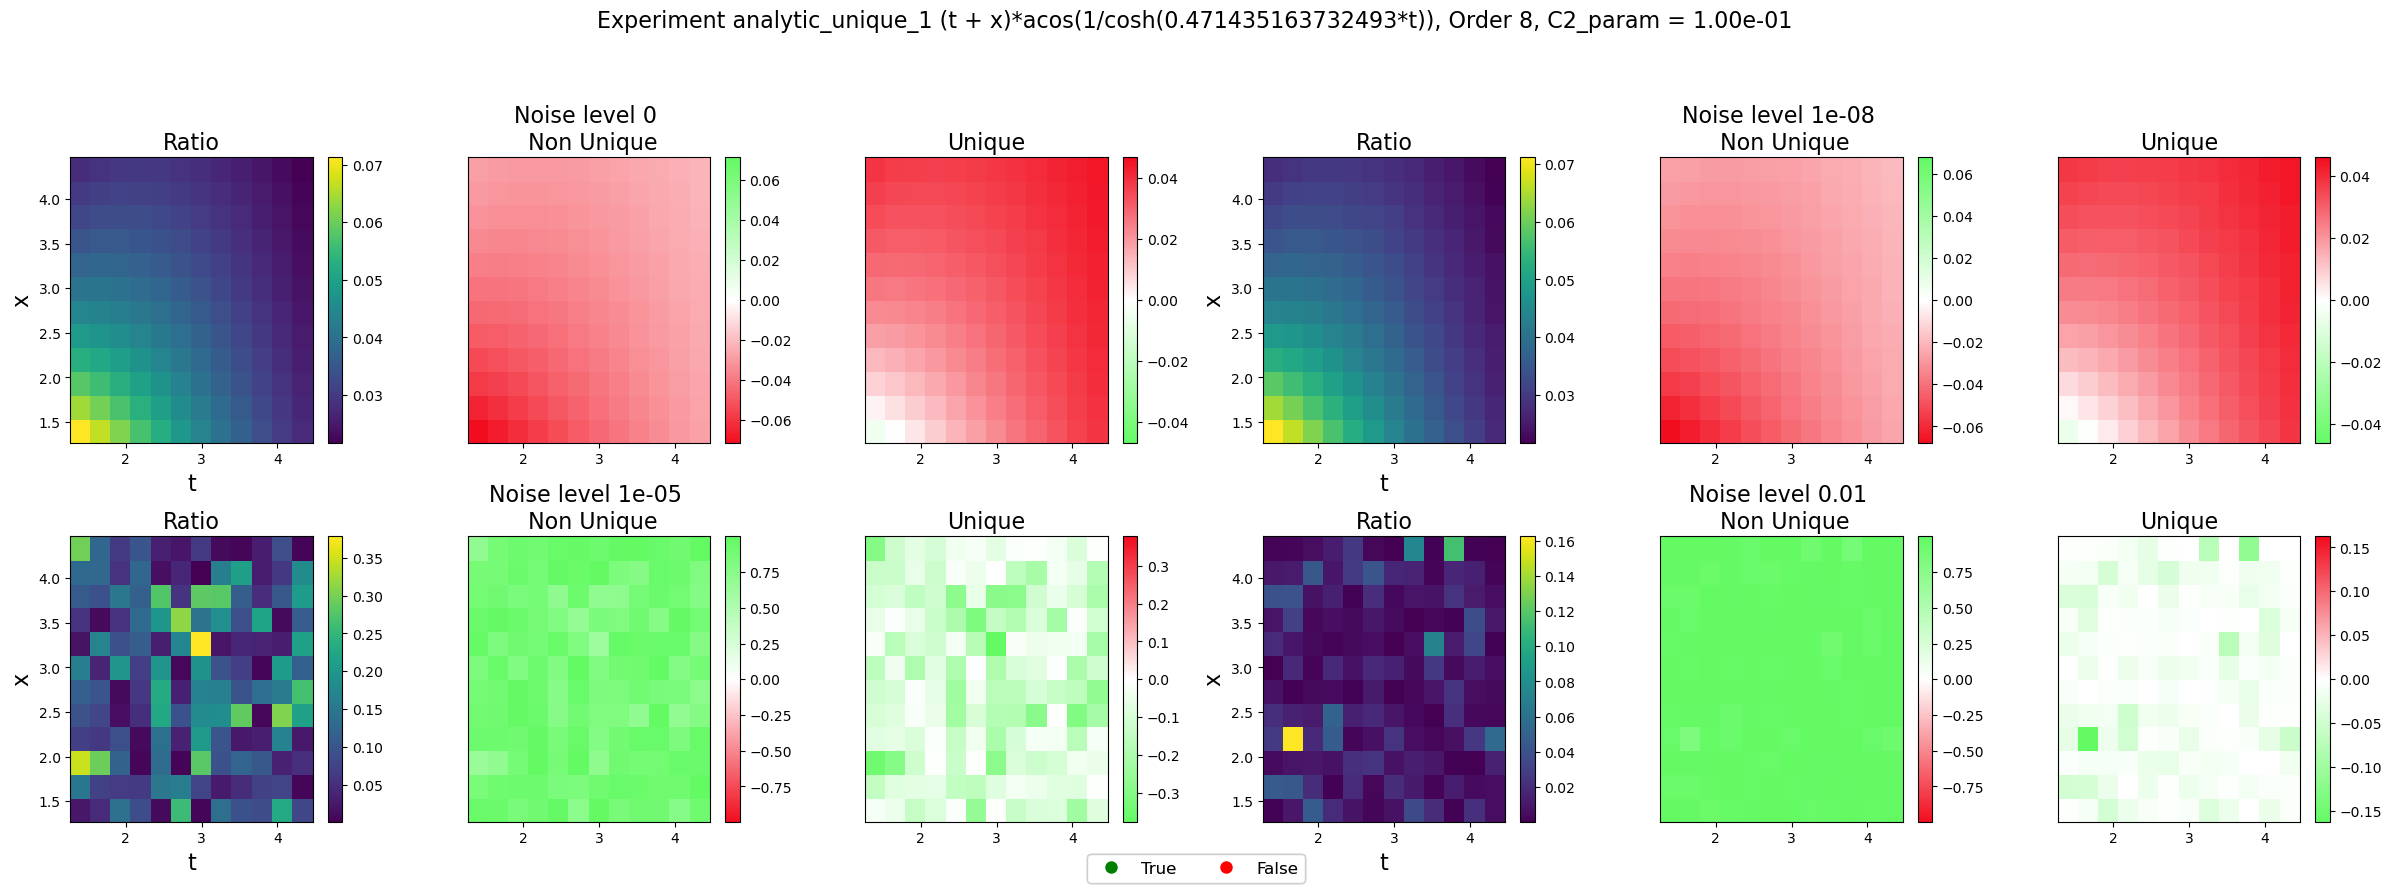

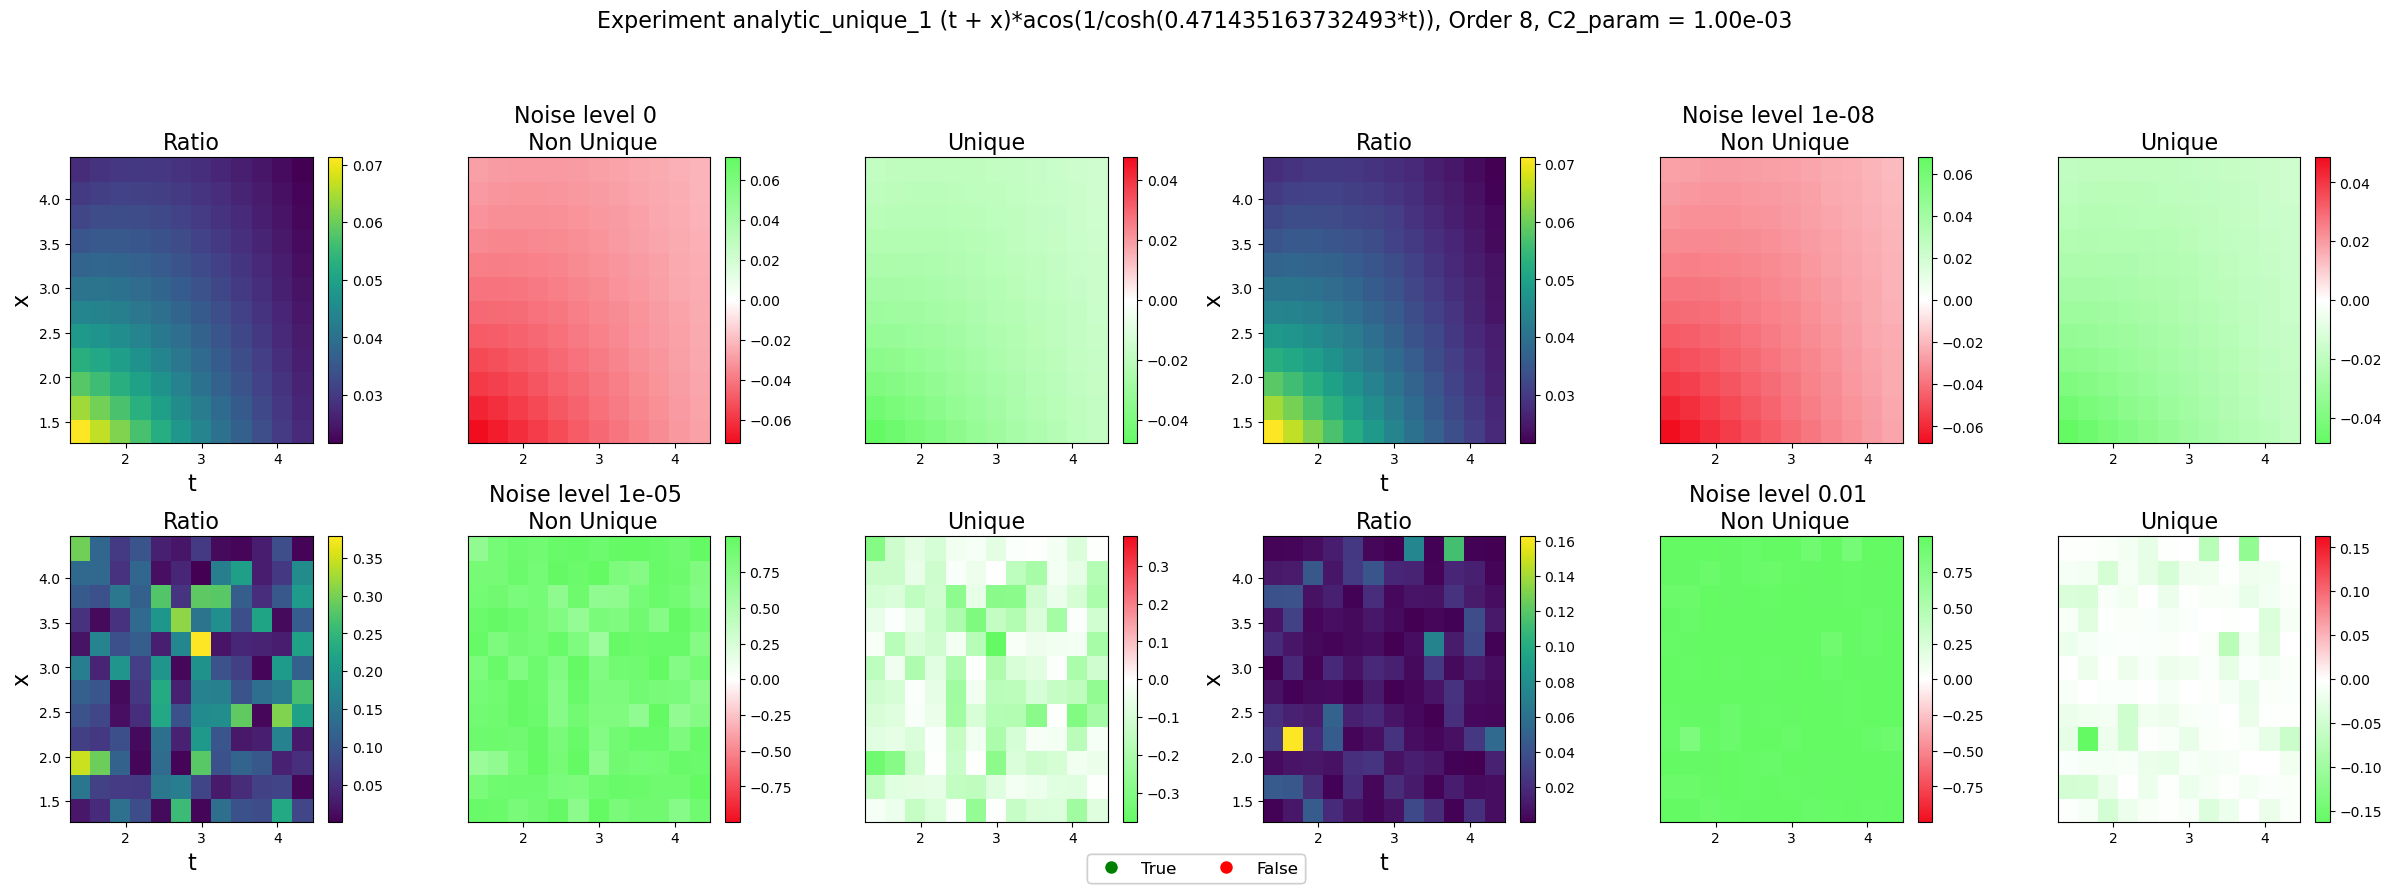

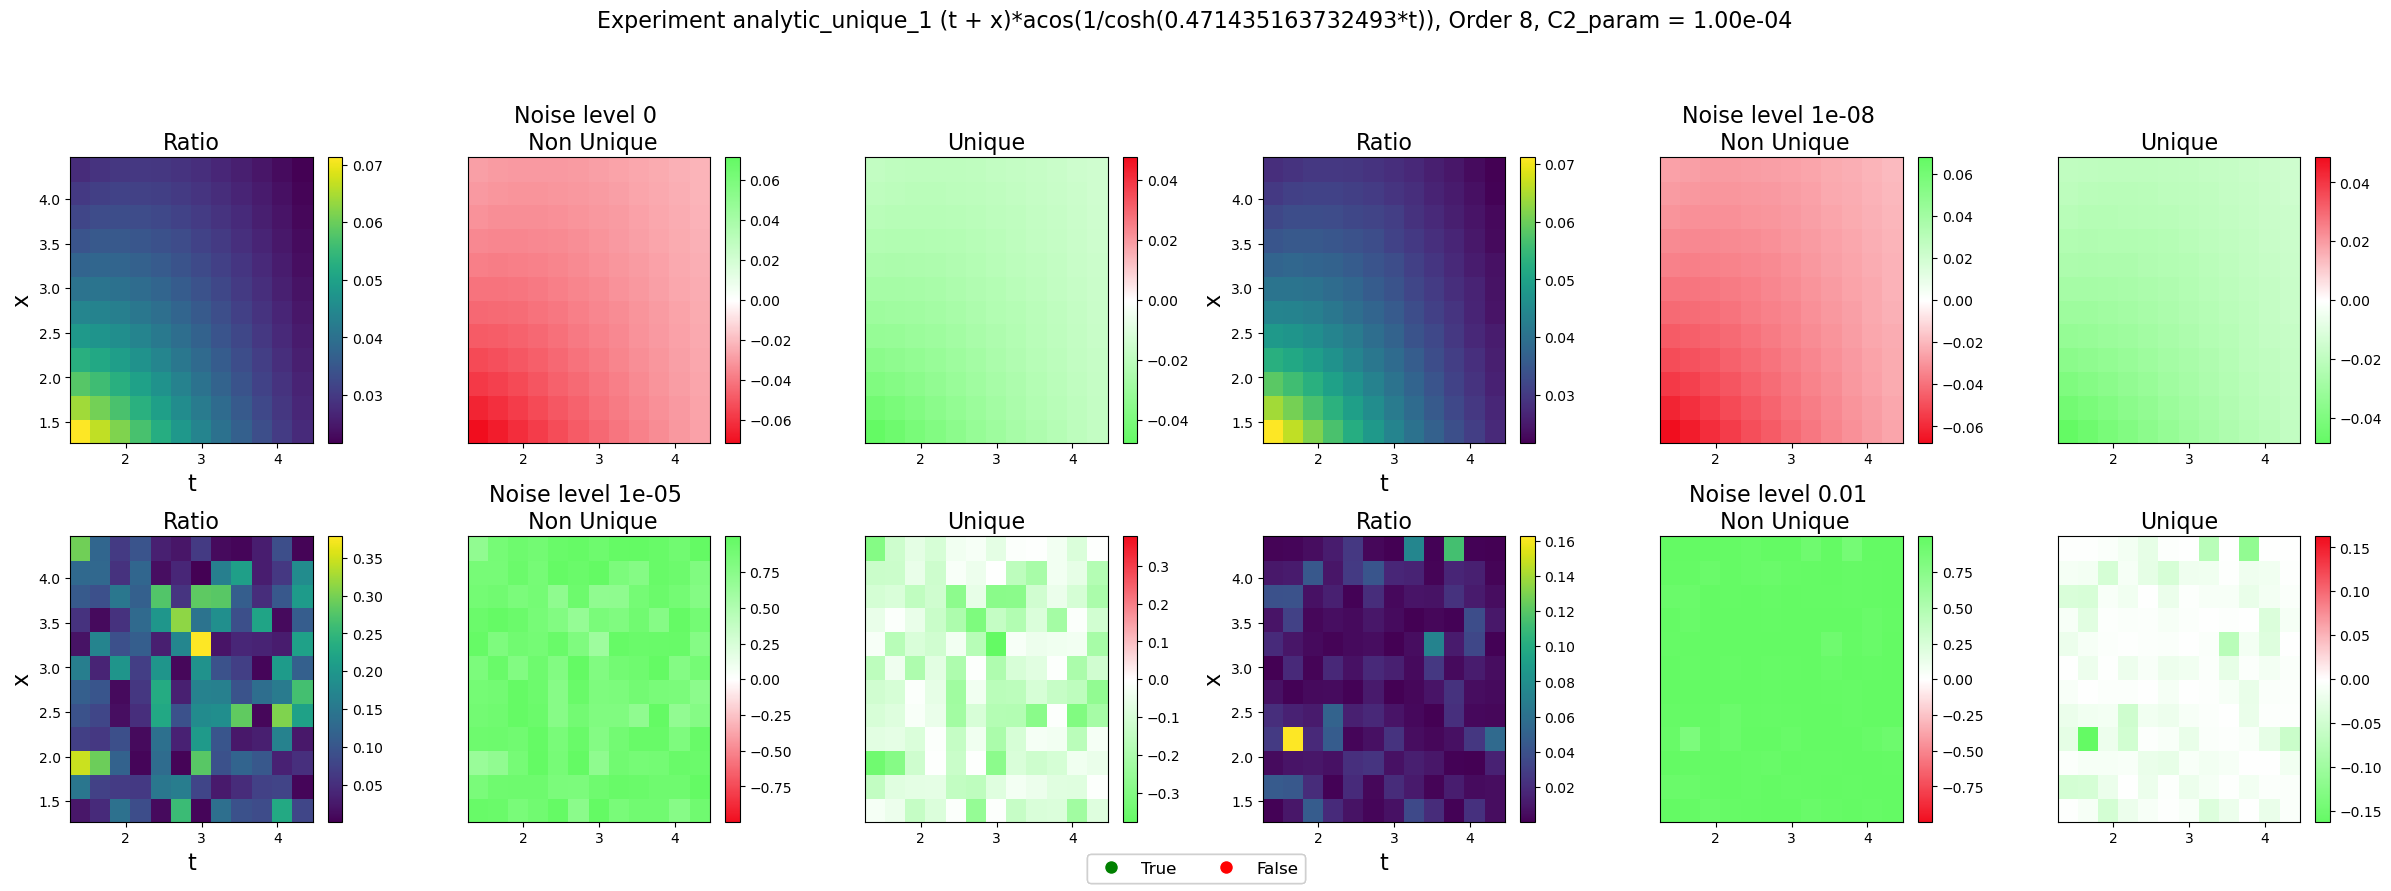

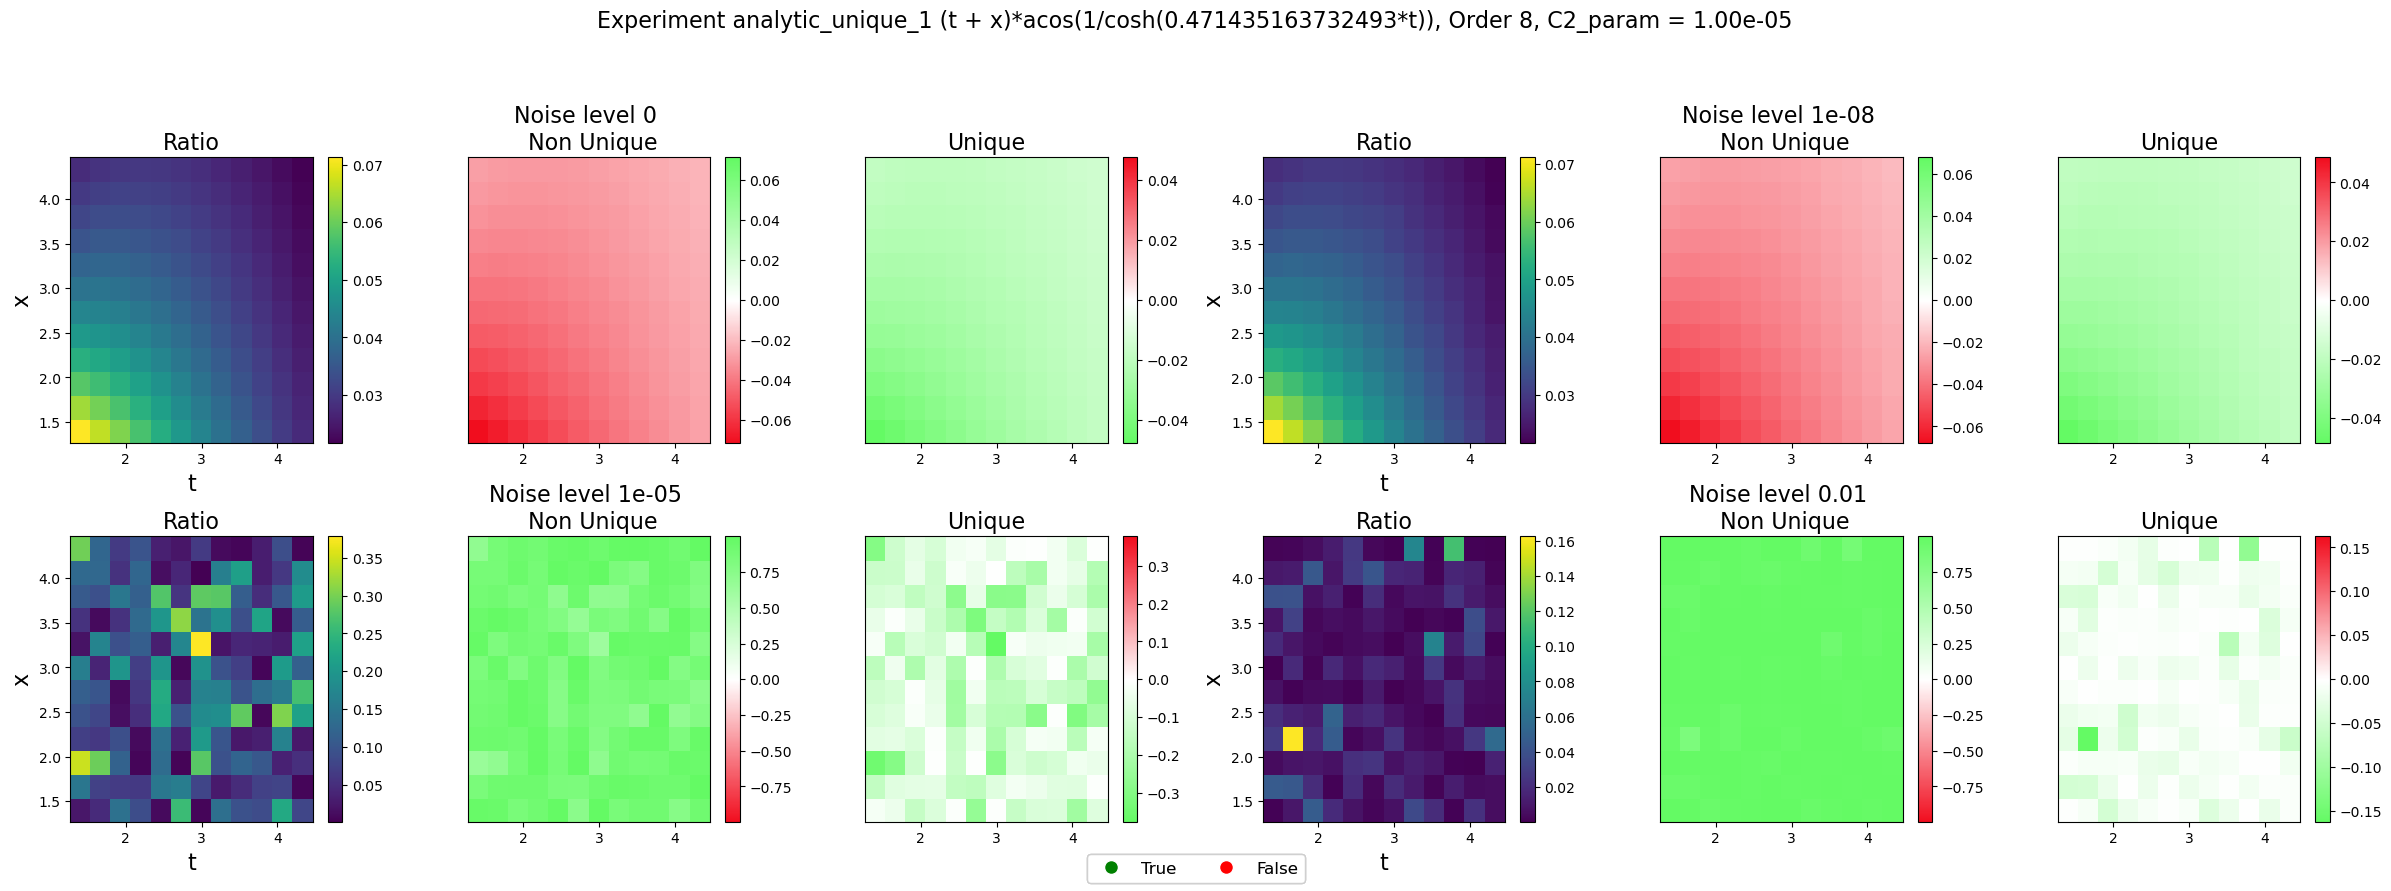

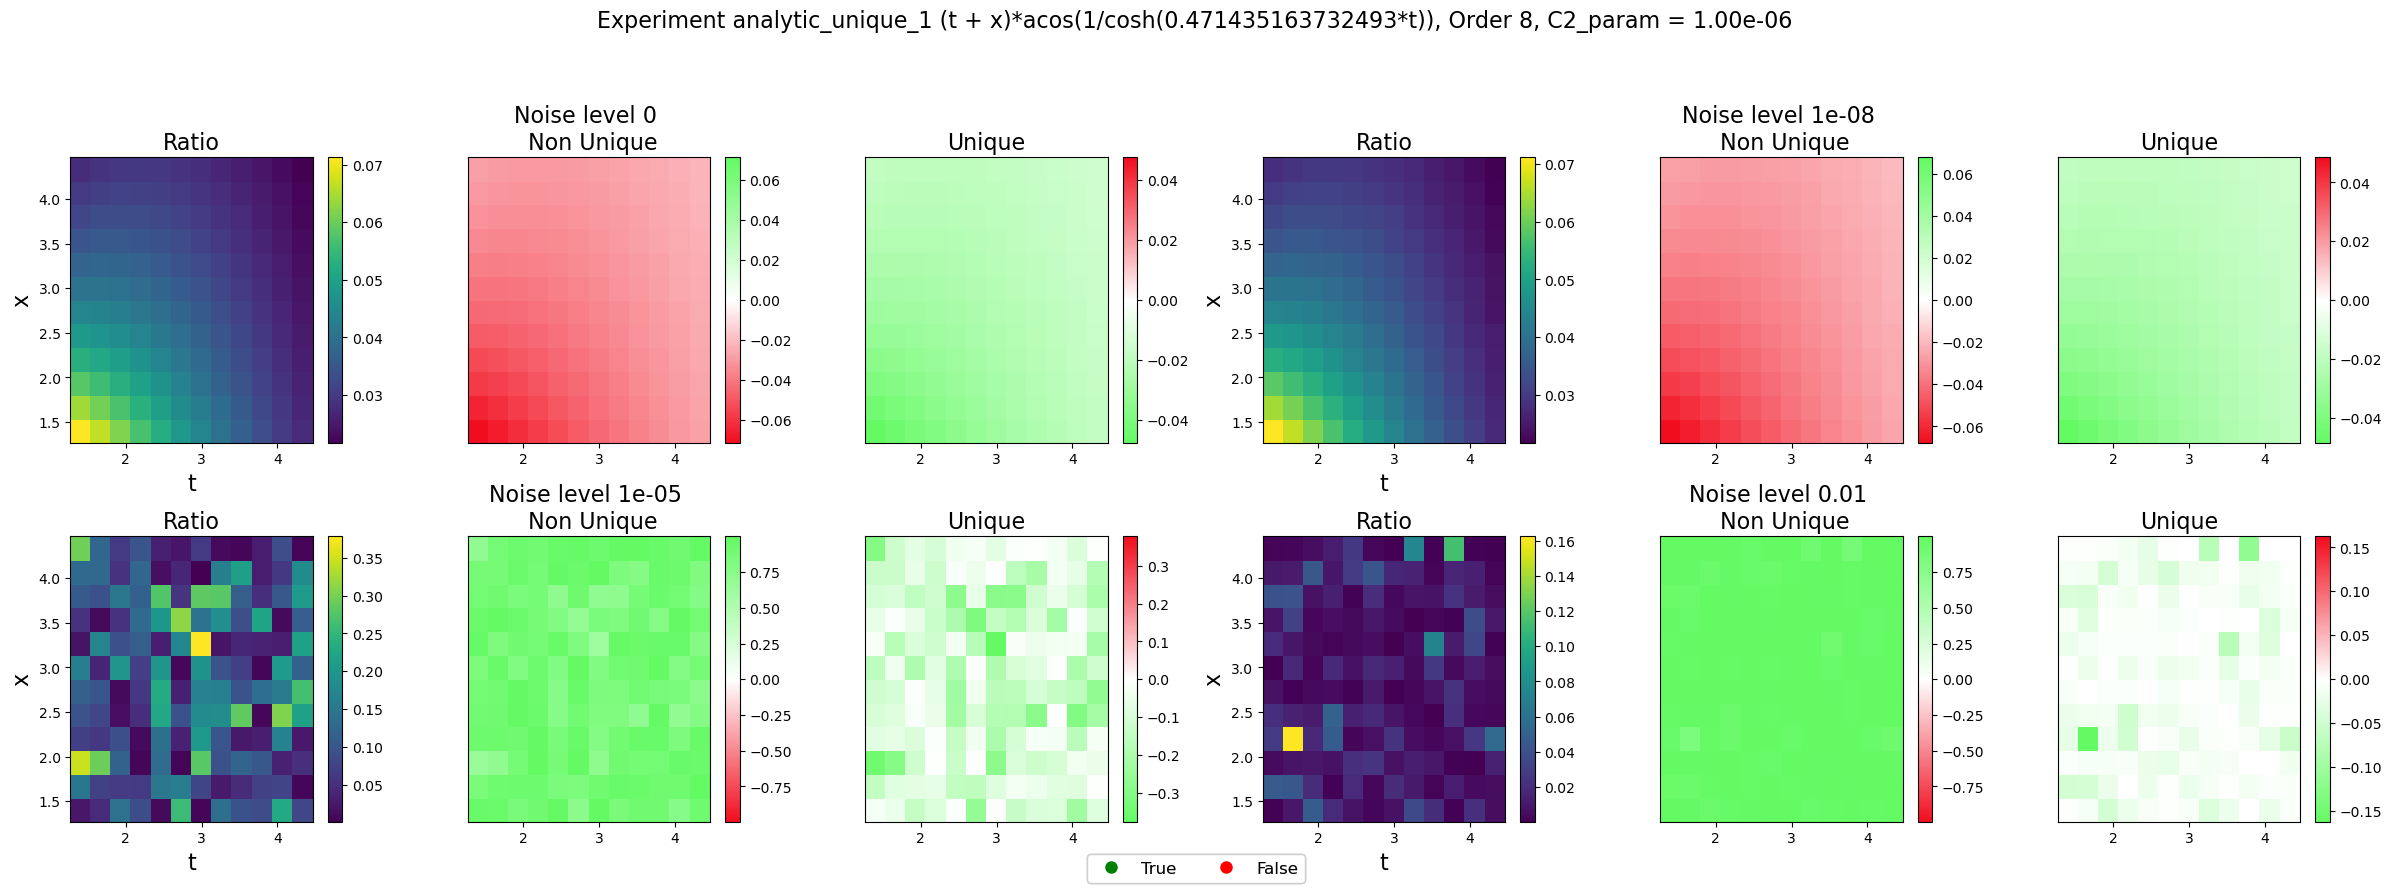

In [27]:
# Unique example
experiment_name = experiment_names[2]
for C2_param in C2_params:
    print(f"C2 = max({C2_param:.3e} * sv_max,0.5*sv_min)")
    perform_experiment(noise_levels,order,experiment_name,C2_param)    

#### Plot how often the problem is correctly classified for specific C2

In [28]:
C2_params=[1.0,0.5,0.25,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
fd_order=8

In [39]:
# Non unique example
experiment_name = experiment_names[1]
true_class = "non unique"

In [40]:
results = get_results_C2(C2_params,noise_levels,fd_order,experiment_name,true_class)

Performing experiment algebraic_nonunique_1 1/(t + x) with order 8
C2 = max(1.000e+00 * sv_max,0.5*sv_min)
C2 = max(5.000e-01 * sv_max,0.5*sv_min)
C2 = max(2.500e-01 * sv_max,0.5*sv_min)
C2 = max(1.000e-01 * sv_max,0.5*sv_min)
C2 = max(1.000e-02 * sv_max,0.5*sv_min)
C2 = max(1.000e-03 * sv_max,0.5*sv_min)
C2 = max(1.000e-04 * sv_max,0.5*sv_min)
C2 = max(1.000e-05 * sv_max,0.5*sv_min)
C2 = max(1.000e-06 * sv_max,0.5*sv_min)


In [41]:
df_analysis = get_df_analysis(results)

In [42]:
check_classification_max_correct_noise_level(df_analysis,C2_params,results)

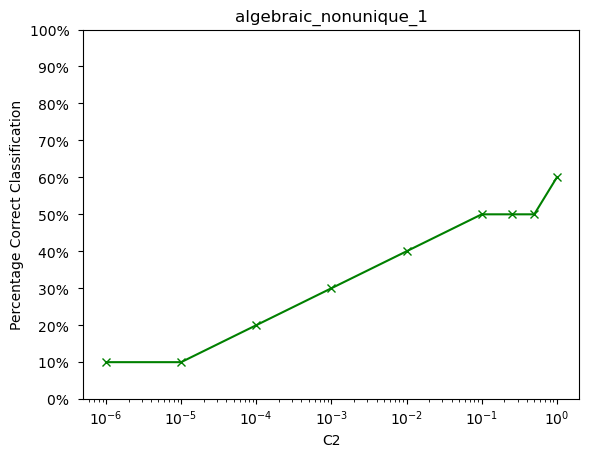

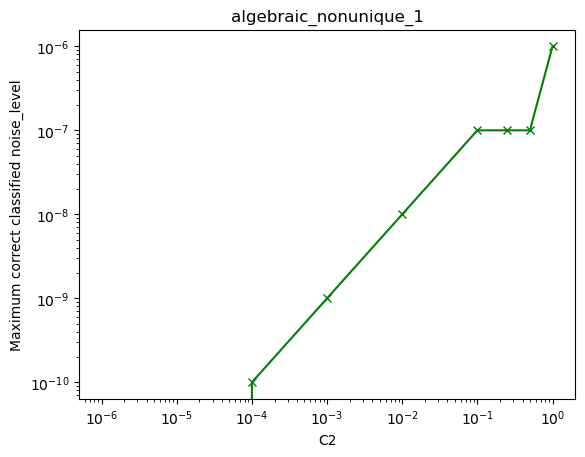

In [43]:
plot_results_C2(experiment_name,df_analysis,noise_levels)
plot_results_C2_noise_level(experiment_name,df_analysis,noise_levels)

In [35]:
# Unique example
experiment_name = experiment_names[2]
true_class = "unique"

In [36]:
results = get_results_C2(C2_params,noise_levels,fd_order,experiment_name,true_class)

Performing experiment analytic_unique_1 (t + x)*acos(1/cosh(0.471435163732493*t)) with order 8
C2 = max(1.000e+00 * sv_max,0.5*sv_min)
C2 = max(5.000e-01 * sv_max,0.5*sv_min)
C2 = max(2.500e-01 * sv_max,0.5*sv_min)
C2 = max(1.000e-01 * sv_max,0.5*sv_min)
C2 = max(1.000e-02 * sv_max,0.5*sv_min)
C2 = max(1.000e-03 * sv_max,0.5*sv_min)
C2 = max(1.000e-04 * sv_max,0.5*sv_min)
C2 = max(1.000e-05 * sv_max,0.5*sv_min)
C2 = max(1.000e-06 * sv_max,0.5*sv_min)


In [37]:
df_analysis = get_df_analysis(results)
check_classification_max_correct_noise_level(df_analysis,C2_params,results)

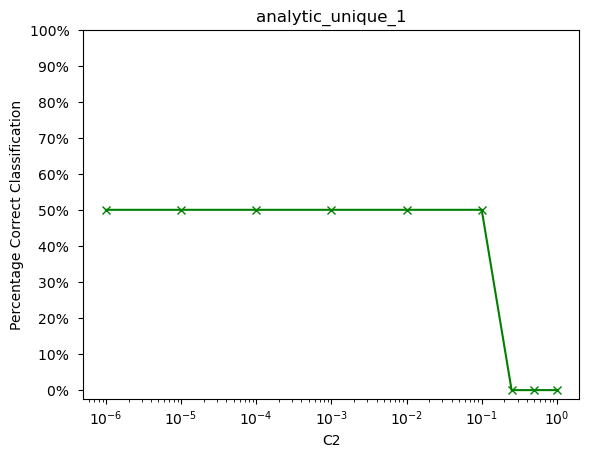

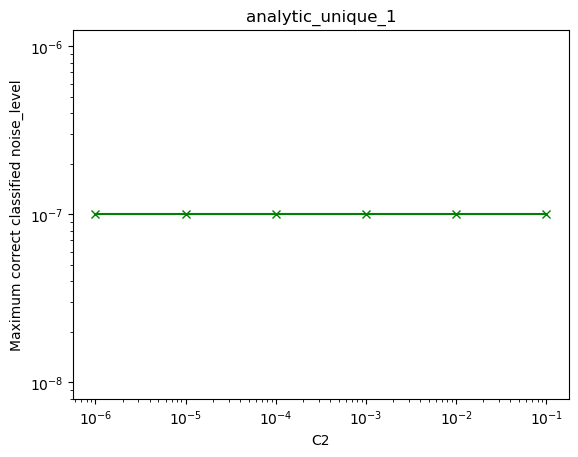

In [38]:
plot_results_C2(experiment_name,df_analysis,noise_levels)
plot_results_C2_noise_level(experiment_name,df_analysis,noise_levels)